# Measuring MTF from Blocks in Philips PIQT (Philips Scans)

In [1]:
%matplotlib inline

from warnings import warn
    
import numpy as np
from numpy.fft import rfft, fftshift, fft, fftfreq

from scipy.ndimage.interpolation import zoom as ndizoom
from scipy.optimize import curve_fit, minimize_scalar
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from scipy.special import erf, erfc, sici
from scipy.signal import hamming

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

from skimage.exposure import rescale_intensity
from skimage.filters import sobel

import matplotlib.pyplot as plt

from ipywidgets import interact, fixed

from dcmfetch import fetch_series
from mriqa.phantoms import phantom_mask_2d, find_phantom
from mriqa.tools import show_mosaic, find_phantom, all_ims
from mriqa.dcmio import pix_spacing_yx

## Images of PIQT Phantom
A single acquisition, ideally 512<sup>2</sup> and 3mm, probably *with* uniformity correction but *without* distortion correction. 

Matrix: (256, 256)


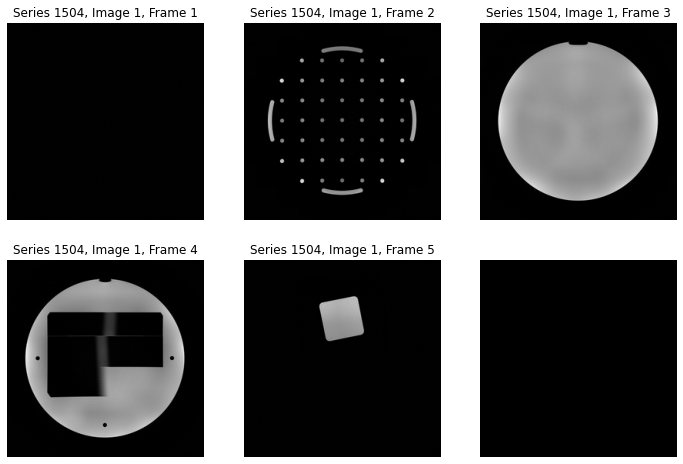

In [2]:
# PIQT: Distortion
# SE: Axial, Phase RL
dobjs = fetch_series(patid='AQA20210318NBTMR12', stuid='663860893', sernos=[1504], imagesonly=True)
show_mosaic(dobjs)
print(f'Matrix: {dobjs[0].Columns, dobjs[0].Rows}')

Not ideal, these are `256*256` images....

A description of the position of the block within the phantom.

Note we can't use this slice to get the centre of the phantom as the block is offfset but we can use the flood slice for that.

We also don't know the rotation, but we can assume it is small enough that we can define a ROI that always includes all of the mtf block. The actual angle we can deduce by fitting straight lines to the edges.

In [3]:
PIQTMTF = {
    'Diameter': 190,
    'PD': 1.0,
    'T1': 500.0,
    'T2': 500.0,
    'Features': {
        'Blocks': [
            ((-45, -95), (90, 90)) # mm wrt isocentre?
        ]
    }
}

PIQTSNR = {
    'Diameter': 190,
    'PD': 1.0,
    'T1': 500.0,
    'T2': 500.0
}

Get the image arrays and the pixel dimensions. In a Philips acquisition, the slices will be frames in a multiframe. For now we'll assume the pixels are square.

In [4]:
# Philips multiframe, snr and mtf frames at offsets 2 and 4
dobj = dobjs[0]
snr_image, mtf_image = dobj.pixel_array[[2, 4], :, :]
pix_dims = pix_spacing_yx(dobj)

# Assume square pixels
assert np.isclose(*pix_dims)

print(f'Pixel Dimensions: {pix_dims}')
print(f'Image Matrix: {snr_image.shape}')

Pixel Dimensions: (0.96875, 0.96875)
Image Matrix: (256, 256)


Need to get the centre of the phantom from the uniformity section as it's difficult from just the isolated block, which is offset.

In [5]:
expected_radius = PIQTSNR['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(snr_image, expected_radius=expected_radius)
print(f'Phantom centre (x, y): {centre_x}, {centre_y}, radius: {radius}')

Phantom centre (x, y): 127, 127, radius: 104


We can assume then that the rotation is not too severe and we can place a fixed box around the square mtf block.

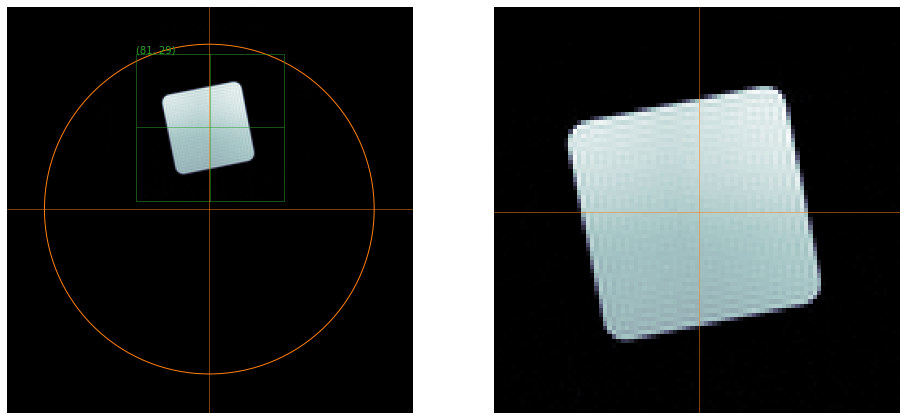

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mtf_image, cmap='bone')
axs[0].axis('off')
axs[0].grid(False)
nrows, ncols = mtf_image.shape

axs[0].axvline(centre_x, linewidth=0.5, color='C1')
axs[0].axhline(centre_y, linewidth=0.5, color='C1')
axs[0].add_artist(
    plt.Circle((centre_x, centre_y), radius, color='C1', fill=False)
)

phantom = PIQTMTF
blocks = phantom['Features']['Blocks']

(x, y), (dx, dy) = np.array(blocks[0]) / pix_dims
# are we missing an off-by-one adjustment here?
x += centre_x
y += centre_y

x = int(round(x))
y = int(round(y))
dx = int(round(dx))
dy = int(round(dy))

axs[0].text(x, y, f'({x}, {y})', color='C2')
axs[0].add_artist(
    plt.Rectangle((x, y), dx, dy, color='C2', fill=False, linewidth=0.5)
)
axs[0].vlines([x+dx/2], y, y+dy, color='C2', linewidth=0.5)
axs[0].hlines([y+dy/2], x, x+dx, color='C2', linewidth=0.5)

roi = mtf_image[y:y+dy, x:x+dx]

axs[1].imshow(roi, cmap='bone')
axs[1].axis('off')
axs[1].grid(False)
nrows, ncols = roi.shape

axs[1].axvline(ncols/2, linewidth=0.5, color='C1')
axs[1].axhline(nrows/2, linewidth=0.5, color='C1');

Once we have bounding box we can fit to edges for rotation or just a bright square and a correlation match.

Getting the rotation is a bit awkward. We could fit all the edges and take the average of the angles to the horizontal or vertical (as appropriate). Ie just add 90 degrees the angles from the two side edges. 

We would like to have a known block angle but as we can't rely on the phantom alignment and we can't internally distinguish a rotation in any other way.

Could fit a general model as before or maybe all together a bright square of variable position, size and angle with a quadratic brightness variation and gaussian edge blurring. All we wan't out is the position and angle and we can put pretty tight box constraits on all the parameters.

Note also the rounded corners that we'll need to exclude.

We'll look at the top edge manually for now.

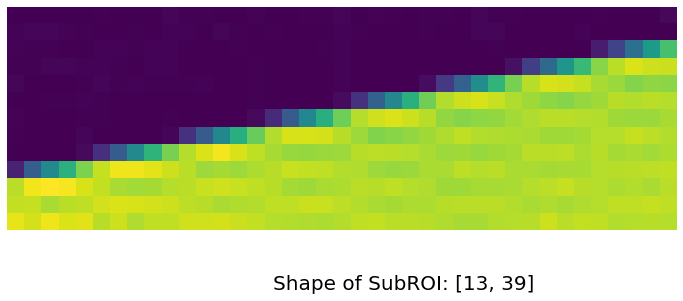

In [7]:
subroi = roi[65:78, 33:72]
subroi = np.rot90(subroi, 2)
plt.figure(figsize=(12, 5))
plt.imshow(subroi, cmap='viridis')
plt.text(15, 16, 'Shape of SubROI: %s' % list(subroi.shape), fontsize=20);
plt.axis('off')
plt.grid(False)

### Finding the Block and Edges

We can do a hough line transform to get the main faces of the blocks.
Then do intersections with adjacent lines to get a line *segment* 

From the line *segment* between the two intersections we then want to get the coordinates of a rectangular ROI:

- For the *horizontal* edges we can do this as follows:
 - ylimits are a bit below ymin and a bit above ymax, xlimits are bit above xmin and a bit below xmax
- For the *vertical* edges
 - ylimits are a bit above ymin and a bit below ymax, xlimits are bit below xmin and a bit above xmax
where growing, the margin is quite large, where shrinking, it's onl a little (say 10% of the segment length)



In [8]:
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.morphology import binary_erosion, binary_dilation, disk
from matplotlib.patches import Rectangle

def intersection(line1, line2):
    """
    Intersection of two lines in Hesse normal form.
    See https://stackoverflow.com/a/383527/5087436
    """
    theta1, rho1 = line1
    theta2, rho2 = line2
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = [rho1, rho2]

    x0, y0 = np.linalg.solve(A, b)
    return x0, y0

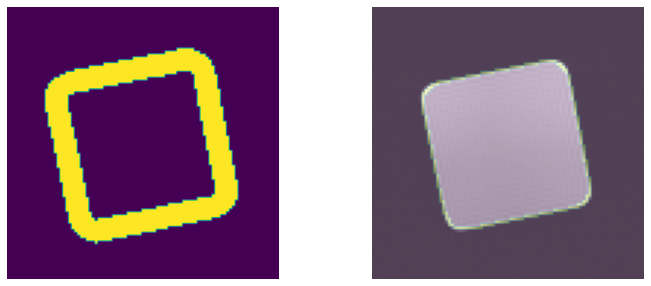

In [9]:
# We may want to adjust first to place the block in the centre of the FOV ...

# Rough edges with threshold and morphology and then Canny within that
# May want to use more robust threshold, especially as some intensity variation
mask = roi > roi.mean()
mask = binary_dilation(mask, disk(4)) & ~binary_erosion(mask, disk(4))
edges = canny(roi/roi.mean(), sigma=3) & mask

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(mask)
axs[1].imshow(edges, alpha=0.5)
axs[1].imshow(roi, cmap='gray', alpha=0.5)
axs[0].axis(False)
axs[1].axis(False);


In [10]:
# Hough Line Transform
tested_angles = np.r_[
    np.linspace(-np.pi / 8, np.pi / 8, 60),
    np.linspace(3*np.pi / 8, 5*np.pi / 8, 60)
                      
]
h, theta, d = hough_line(edges, theta=tested_angles)

# Pick 4 best lines
peaks = hough_line_peaks(h, theta, d)
x0_x1 = np.array([0, roi.shape[1]])
angles, dists = peaks[1][:4], peaks[2][:4]

print([np.degrees(angle) for angle in angles])
print(dists)
print(x0_x1)

angles = [angles[1], angles[2], angles[3], angles[0]]
dists = [dists[1], dists[2], dists[3], dists[0]]
line1 = angles[0], dists[0]
line2 = angles[1], dists[1]
line3 = angles[2], dists[2]
line4 = angles[3], dists[3]

for i in range(4):
    print(f'Hough line{i+1}: {np.degrees(angles[i])} {dists[i]}')
    
p1 = np.array(intersection(line1, line2))
p2 = np.array(intersection(line1, line3))

# centre of line segment
p0 = (p2 + p1) / 2

print('Intersections:', p1, p2)
print('Centre:', p0)

[78.9406779661017, 78.9406779661017, -11.059322033898304, -10.296610169491526]
[80. 29. 61. 11.]
[ 0 93]
Hough line1: 78.9406779661017 29.0
Hough line2: -11.059322033898304 61.0
Hough line3: -10.296610169491526 11.0
Hough line4: 78.9406779661017 80.0
Intersections: [65.43010695 16.76010457] [15.98071215 26.42523655]
Centre: [40.70540955 21.59267056]


Line Segment Length = 50.38509127064451
p1 = [65.43010695 16.76010457]
p2 = [15.98071215 26.42523655]
ps = [[65.43010695 16.76010457]
 [15.98071215 26.42523655]]
Starting bbox: [[15.98071215 16.76010457]
 [65.43010695 26.42523655]]
dx, dy = (49.45, 9.67)
Adjusted bbox [[19.27733847 11.92753858]
 [62.13348063 31.25780254]]


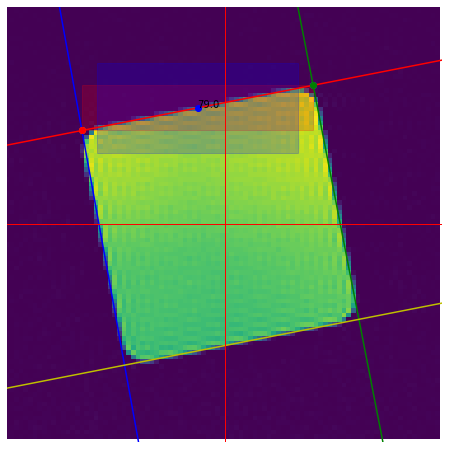

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(roi)
for angle, dist, colour in zip(angles, dists, 'rgby'):
    y0_y1 = (dist - x0_x1 * np.cos(angle)) / np.sin(angle)
    ax.plot(x0_x1, y0_y1, f'-{colour}')

ax.set_xlim(x0_x1)
ax.set_ylim((roi.shape[0], 0))

ax.axhline(roi.shape[0]/2, color='red', linewidth=1)
ax.axvline(roi.shape[1]/2, color='red', linewidth=1)

ax.plot(*intersection(line1, line2), 'o')
ax.plot(*intersection(line1, line3), 'o')

ax.plot(*p1, 'o', color='green')
ax.plot(*p2, 'o', color='red')
ax.plot(*p0, 'o', color='blue')


ax.text(*p0, np.round(np.degrees(angles[0])))
line_segment_length = np.hypot(*(p1 - p2))
print(f'Line Segment Length = {line_segment_length}')

print('p1 =', p1)
print('p2 =', p2)

ps = np.array([p1, p2])
print('ps =', ps)
bbox = np.asarray([
    np.min(ps, axis=0),
    np.max(ps, axis=0)
])

print(f'Starting bbox: {bbox}')

# [[minx, miny], [maxx, maxy]]
ax.add_patch(
    Rectangle(
        bbox[0],
        bbox[1][0] - bbox[0][0],
        bbox[1][1] - bbox[0][1],
        fill=True,
        alpha=0.2,
        color='red'
    )
)  

# some arbitrary adjustment of bbox here ...

dx, dy = abs(bbox[1][0] - bbox[0][0]), abs(bbox[1][1] - bbox[0][1])
print(f'dx, dy = ({dx:0.2f}, {dy:0.2f})')
bbox[0] -= (-dx/15, dy/2)
bbox[1] += (-dx/15, dy/2)

print(f'Adjusted bbox {bbox}')

ax.add_patch(
    Rectangle(
        bbox[0],
        bbox[1][0] - bbox[0][0],
        bbox[1][1] - bbox[0][1],
        fill=True,
        alpha=0.2,
        color='blue'
    )
)

ax.axis(False)

bbox = np.round(bbox).astype(int)

Hough line1: 78.9406779661017 29.0
Hough line2: -11.059322033898304 61.0
Hough line3: -10.296610169491526 11.0
Hough line4: 78.9406779661017 80.0
Intersections: [65.43010695 16.76010457] [15.98071215 26.42523655]
centre: [40.70540955 21.59267056]
Line Segment Length = 50.38509127064451
p1 = [65.43010695 16.76010457]
p2 = [15.98071215 26.42523655]
ps = [[65.43010695 16.76010457]
 [15.98071215 26.42523655]]
Starting bbox: [[15.98071215 16.76010457]
 [65.43010695 26.42523655]]
dx, dy = (49.45, 9.67)
Adjusted bbox [[19.27733847 11.92753858]
 [62.13348063 31.25780254]]
roi[12:31, 19:62]


(93, 93)

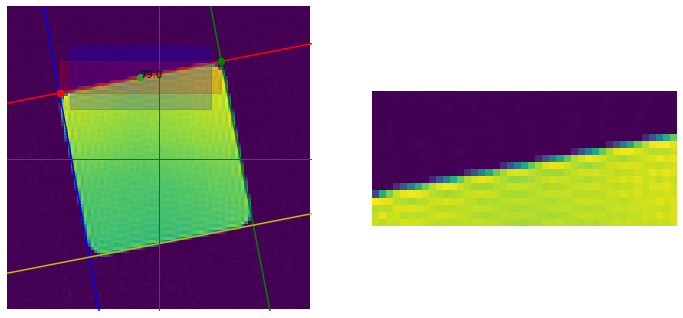

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax = axs[0]
ax.imshow(roi)
for angle, dist, colour in zip(angles, dists, 'rgby'):
    y0_y1 = (dist - x0_x1 * np.cos(angle)) / np.sin(angle)
    ax.plot(x0_x1, y0_y1, f'-{colour}')

ax.set_xlim(x0_x1)
ax.set_ylim((roi.shape[0], 0))
ax.axis(False)
ax.axhline(roi.shape[0]/2, color='red', linewidth=1)
ax.axvline(roi.shape[1]/2, color='red', linewidth=1)

line1 = angles[0], dists[0]
line2 = angles[1], dists[1]
line3 = angles[2], dists[2]
line4 = angles[3], dists[3]

for i in range(4):
    print(f'Hough line{i+1}: {np.degrees(angles[i])} {dists[i]}')

ax.plot(*intersection(line1, line2), 'o')
ax.plot(*intersection(line1, line3), 'o')

p1 = np.array(intersection(line1, line2))
p2 = np.array(intersection(line1, line3))

# centre of line segment
p0 = (p2 + p1) /2

print('Intersections:', p1, p2)
print('centre:', p0)
        
ax.plot(*p1, 'o', color='green')
ax.plot(*p2, 'o', color='red')
ax.plot(*p0, 'o')
ax.text(*p0, np.round(np.degrees(angles[0])))
line_segment_length = np.hypot(*(p1 - p2))

print(f'Line Segment Length = {line_segment_length}')

print('p1 =', p1)
print('p2 =', p2)

ps = np.array([p1, p2])
print('ps =', ps)
bbox = np.asarray([
    np.min(ps, axis=0),
    np.max(ps, axis=0)
])

print(f'Starting bbox: {bbox}')

# [[minx, miny], [maxx, maxy]]
ax.add_patch(
    Rectangle(
        bbox[0],
        bbox[1][0] - bbox[0][0],
        bbox[1][1] - bbox[0][1],
        fill=True,
        alpha=0.2,
        color='red'
    )
)  

# some arbitrary adjustment of bbox here ...

dx, dy = abs(bbox[1][0] - bbox[0][0]), abs(bbox[1][1] - bbox[0][1])
print(f'dx, dy = ({dx:0.2f}, {dy:0.2f})')
bbox[0] -= (-dx/15, dy/2)
bbox[1] += (-dx/15, dy/2)

print(f'Adjusted bbox {bbox}')

ax.add_patch(
    Rectangle(
        bbox[0],
        bbox[1][0] - bbox[0][0],
        bbox[1][1] - bbox[0][1],
        fill=True,
        alpha=0.2,
        color='blue'
    )
)
bbox = np.round(bbox).astype(int)

ax = axs[1]

print(f'roi[{bbox[0][1]}:{bbox[1][1]}, {bbox[0][0]}:{bbox[1][0]}]')
subroi = roi[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
ax.imshow(subroi)
ax.axis(False)
# from the offsets we should be able to put boxes round the edges, the intersections tell as the limits of the line segments
# then take a bit off for the rounded edges.
roi.shape

In [13]:
def get_mtf_edges(roi):
    def centre_angle(roi, theta, dist):
        """
        Angle around image centre to sort edges by
        """
        theta = np.pi/2 - theta
        if dist > np.hypot(*np.array(roi.shape) / 2):
            theta += np.pi
        return np.mod(theta, 2*np.pi)

    mask = roi > roi.mean()
    mask = binary_dilation(mask, disk(3)) & ~binary_erosion(mask, disk(3))
    edges = mask & canny(roi/roi.mean(), sigma=3) & mask

    # Hough Line Tranform
    tested_angles = np.r_[
        np.linspace(-np.pi / 8, np.pi / 8, 60),
        np.linspace(3*np.pi / 8, 5*np.pi / 8, 60)

    ]
    h, theta, d = hough_line(edges, theta=tested_angles)

    # Pick 4 best lines
    peaks = hough_line_peaks(h, theta, d)
    x0_x1 = np.array([0, roi.shape[1]])
    
    angles, dists = peaks[1][:4], peaks[2][:4]

    # Sort around centre of block
    angles, dists = zip(*sorted(
        zip(angles, dists),
        key=lambda pair: centre_angle(roi, pair[0], pair[1])
    ))

    return angles, dists

In [14]:
def get_subrois(roi, angles, dists):

    def extract_bbox(line1, line2, line3):
        p1 = np.array(intersection(line1, line2))
        p2 = np.array(intersection(line1, line3))
        line_segment_length = np.hypot(*(p1 - p2))
        #print(line_segment_length)
        ps = np.array([p1, p2])
        #print(f'Intersections at {p1} and {p2}')
        #print(f'Corners at {np.min(ps, axis=0)} and {np.max(ps, axis=0)}')

        return np.array([
            np.min(ps, axis=0),
            np.max(ps, axis=0)
        ])

    ny, nx = roi.shape
    #print('All lines:', list(zip(np.degrees(angles), dists)))
    # nb hough angle defined such that 0 is vertical 90 is horizontal so lines near 90 are *horizontal*
    horiz_angles, horiz_dists = zip(*[(angle, dist) for angle, dist in zip(angles, dists) if abs(np.degrees(angle)) > 45])
    #print('Horizontal lines:', list(zip(np.degrees(horiz_angles), horiz_dists)))

    vert_angles, vert_dists = zip(*[(angle, dist) for angle, dist in zip(angles, dists) if abs(np.degrees(angle)) <= 45])
    #print('Vertical lines:', list(zip(np.degrees(vert_angles), vert_dists)))

    subrois = {}

    # for each horizontal edge find its intersections with the vertical edges
    for horiz_angle, horiz_dist in zip(horiz_angles, horiz_dists):
        line1 = horiz_angle, horiz_dist
        line2 = vert_angles[0], vert_dists[0]
        line3 = vert_angles[1], vert_dists[1]

        #print(f'horiz line {line1} intersections with vertical lines {line2} and {line3}')
        bbox = extract_bbox(line1, line2, line3)
        # bbox is [[left, top], [bottom, right]]
        #print(f'Horiz BBox: box={bbox}, height={bbox[1][1]-bbox[0][1]}, width={bbox[1][0]-bbox[0][0]}')
        print(f'Horiz BBox: width={bbox[1][0]-bbox[0][0]:0.1f}, height={bbox[1][1]-bbox[0][1]:0.1f}')

        # arbitrary adjustment of roi box
        width, height = abs(bbox[1][0] - bbox[0][0]), abs(bbox[1][1] - bbox[0][1])
        cx, cy = (bbox[1][0] + bbox[0][0])/2, (bbox[1][1] + bbox[0][1])/2

        bbox[0] -= (-width/10, 0.5*height)
        bbox[1] += (-width/10, 0.5*height)
        bbox = np.round(bbox).astype(int)
        bbox = np.clip(bbox, 0, None)
        bbox[1][0] = np.clip(bbox[1][0], None, nx-1)
        bbox[1][1] = np.clip(bbox[1][1], None, ny-1)

        #print(f'Line Segment Length: {line_segment_length}')
        #print(f'Horiz BBox (Adjusted): box={bbox}, height={bbox[1][1]-bbox[0][1]}, width={bbox[1][0]-bbox[0][0]}')
        #print(f'Horiz BBox (Rounded): box={bbox}, height={bbox[1][1]-bbox[0][1]}, width={bbox[1][0]-bbox[0][0]}')
        #print(f'Horiz BBox (Rounded): width={bbox[1][0]-bbox[0][0]}, height={bbox[1][1]-bbox[0][1]}')
        #print(f'Horiz BBox (Clipped): box={bbox}, height={bbox[1][1]-bbox[0][1]}, width={bbox[1][0]-bbox[0][0]}')

        subroi = roi[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
        #print('Subroi shape:', subroi.shape)
        profile = subroi.sum(axis=1)
        #print('Profile length:', len(profile))
        
        if profile[-1] > profile[0]:
            subrois['Top'] = subroi
            print(f'Top @ {cx}, {cy}')
        else:
            subrois['Bottom'] = np.rot90(subroi, 2)
            print(f'Bottom @ {cx}, {cy}')
    
    # vertical edges
    for vert_angle, vert_dist in zip(vert_angles, vert_dists):
        line1 = vert_angle, vert_dist
        line2 = horiz_angles[0], horiz_dists[0]
        line3 = horiz_angles[1], horiz_dists[1]
        #print(f'veertical line {line1} intersections with vertical lines {line2} and {line3}')

        bbox = extract_bbox(line1, line2, line3)
        #print(f'Vert BBox: box={bbox}, width={bbox[1][1]-bbox[0][1]}, height={bbox[1][0]-bbox[0][0]}')
        print(f'Vert BBox: width={bbox[1][1]-bbox[0][1]:0.1f}, height={bbox[1][0]-bbox[0][0]:0.1f}')
        
        # shrink along edge and grow perpendicular
        # arbitrary adjustment of roi box
        width, height = abs(bbox[1][0] - bbox[0][0]), abs(bbox[1][1] - bbox[0][1])
        cx, cy = (bbox[1][0] + bbox[0][0])/2, (bbox[1][1] + bbox[0][1])/2

        bbox[0] -= (0.5*width, -height/10)
        bbox[1] += (0.5*width, -height/10)
        bbox = np.round(bbox).astype(int)
        bbox = np.clip(bbox, 0, None)
        bbox[1][0] = np.clip(bbox[1][0], None, nx-1)
        bbox[1][1] = np.clip(bbox[1][1], None, ny-1)
        
        #print(f'Line Segment Length: {line_segment_length}')
        #print(f'Vert BBox (Adjusted): box={bbox}, width={bbox[1][1]-bbox[0][1]}, height={bbox[1][0]-bbox[0][0]}')
        #print(f'Vert BBox (Rounded): box={bbox}, width={bbox[1][1]-bbox[0][1]}, height={bbox[1][0]-bbox[0][0]}')
        #print(f'Vert BBox (Rounded): width={bbox[1][1]-bbox[0][1]}, height={bbox[1][0]-bbox[0][0]}')

        subroi = roi[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
        
        #print(f'Subroi shape: {subroi.shape}')
        profile = subroi.sum(axis=0)
        #print(f'Profile length: {len(profile)}')
        if profile[-1] > profile[0]:
            subrois['Right'] = np.rot90(subroi, 3)
            print(f'Right @ {cx}, {cy}')
        else:
            subrois['Left'] = np.rot90(subroi, 1)
            print(f'Left @ {cx}, {cy}')
    return subrois

Horiz BBox: width=49.4, height=9.7
Top @ 40.70540954531196, 21.59267055801356
Horiz BBox: width=50.1, height=9.8
Bottom @ 50.15532903465497, 71.71067393752286
Vert BBox: width=50.2, height=9.1
Right @ 20.539088137728218, 51.51679786770907
Vert BBox: width=50.1, height=9.8
Left @ 70.3216504422387, 41.78654662782735


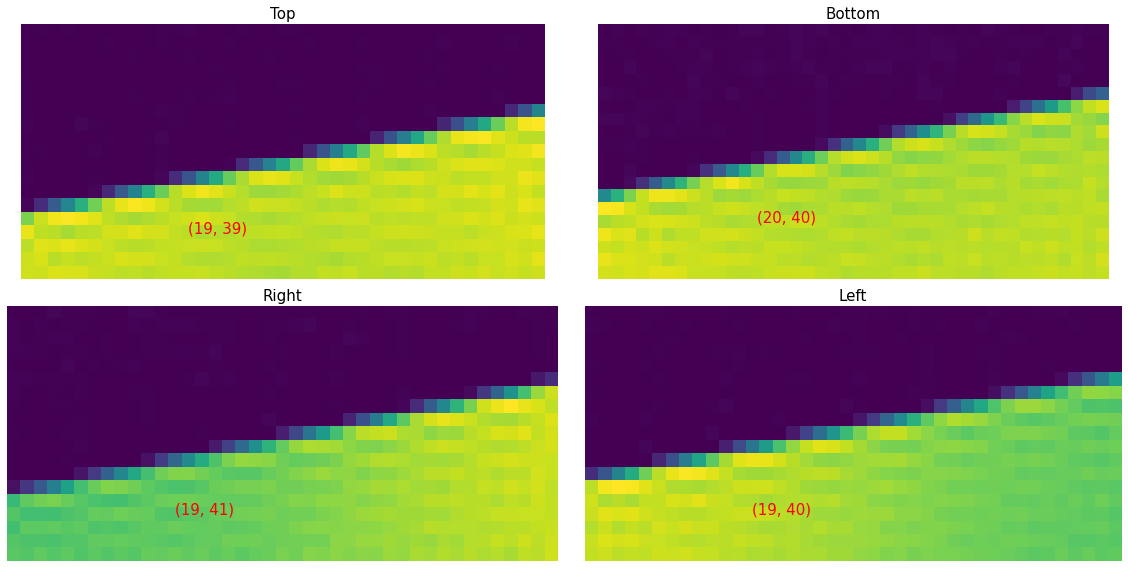

In [15]:
angles, dists = get_mtf_edges(roi)
subrois = get_subrois(roi, angles, dists)

fig, axs = plt.subplots(2, 2, figsize=(16, 8))
for ax, (name, subroi) in zip(axs.flat, subrois.items()):
    ax.imshow(subroi)
    ax.set_title(name, fontsize=15)
    ax.text(12, 15, f'{subroi.shape}', color='r', fontsize=15)
    ax.axis(False)
plt.tight_layout()

## Identify the block edge in the ROI
We could try a simple edge detection first to get the rough slope and offset. We'll try a few different methods.

In [16]:
subroi = subrois['Bottom']

from skimage.filters import roberts, sobel, scharr, prewitt
method_dict = {
    'roberts': roberts,
    'sobel':   sobel,
    'scharr':  scharr,
    'prewitt': prewitt 
}

@interact(method=method_dict)
def show_edges(method):
    plt.figure(figsize=(12, 5))
    edges = method(subroi)
    plt.imshow(subroi, cmap='viridis', alpha=0.5)
    plt.imshow(edges, alpha=0.5)
    plt.grid(None)
    plt.axis('off')
    points = []
    for i, col in enumerate(edges.T):
        x, y = i, np.argmax(col)
        points.append((x, y))
    X, Y = np.asarray(points).T
    X, Y = X[1:-1], Y[1:-1]
    plt.plot(X, Y, '.', markersize=2.5)
    a, b = np.polyfit(X, Y, deg=1)
    plt.plot(X, a*X + b, linewidth=0.75)
    angle = np.degrees(np.arctan(a))
    offset = b
    plt.text(10, 10, '%s: Offset = %0.2f pixels; Angle (to Horizontal) = %0.2f degrees' % (method.__name__, offset, angle), fontsize=16)

interactive(children=(Dropdown(description='method', options={'roberts': <function roberts at 0x7f2038b4baf0>,…

They all actually work pretty well - the roberts is slightly different from the others. We could use this as a starting point for a more general fit and see if it makes any difference. The general function will model the edge thickness and a quadratic gain field as well as the edge position and slope.

In [17]:
subroi = subrois['Bottom']
def edge_fit(roi, method=sobel):
    edges = method(roi)
    points = []
    for i, col in enumerate(edges.T):
        x, y = i, np.argmax(col)
        points.append((x, y))
    X, Y = np.asarray(points).T
    X, Y = X[1:-1], Y[1:-1]
    a, b = np.polyfit(X, Y, deg=1)
    return a, b

for locn in ['Top', 'Right', 'Bottom', 'Left']:
    subroi = subrois[locn]
    a, b = edge_fit(subroi)
    print(locn)
    print(f'Angle = {np.degrees(np.arctan(a)):0.1f} degrees')
    print(f'Intercept = {b:0.1f} pixels')


Top
Angle = -11.3 degrees
Intercept = 13.6 pixels
Right
Angle = -11.2 degrees
Intercept = 13.4 pixels
Bottom
Angle = -11.7 degrees
Intercept = 13.1 pixels
Left
Angle = -10.9 degrees
Intercept = 12.4 pixels


Ah, note the angles are negative as coordinate origin is top-left not bottom-left. Remember to change the sign if this is required at somepoint.

### Modelling the edge in the image
We'll try generating a model of the roi based on a straight edge, a quadratic gain field and a function modelling the edge. This could be an error function (intehral of a Gaussian line spread finction) or a Sine Integral (integral of a sinc line spread function).

An error function for the edge would be simplest but may not well fit the edge ringing we get (the mri signal band limited so in principle the lsf is a sinc)

#### Possible edge functions

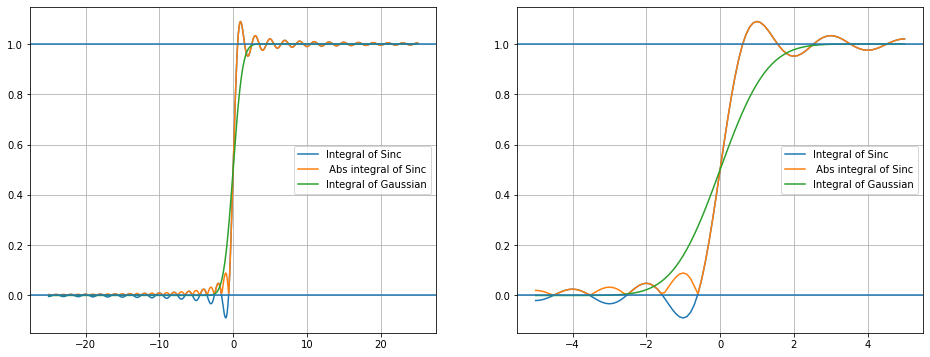

In [18]:
# Sine Integral: nb conventions: sici(x)[0] is the integral (0, x) of the *unnormalised* sinc function sin(x) / x 
# whereas np.sinc is the *normalised* sinc function defined as sin(πx) / πx (from 0, x)
# This means it would correspond to first zero crossing at π rather than at one. We can scale it to match the sinc definition and
# shift it up so the integral goes from -inf to x
si = lambda x: 0.5 + sici(np.pi * x)[0] / np.pi

# The integral (-inf, x) of a unit width Gaussian is phi(x) = 0.5 * (1 + erf(x/sqrt(2)))
phi = lambda x:  0.5 * (1 + erf(x / np.sqrt(2)))

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
x = np.linspace(-25, 25, 501)

axs[0].plot(x, si(x), label='Integral of Sinc')
axs[0].plot(x, abs(si(x)), label=' Abs integral of Sinc')
axs[0].plot(x, phi(x), label='Integral of Gaussian')
axs[0].grid(True)
axs[0].axhline(0)
axs[0].axhline(1)
axs[0].legend()

x = np.linspace(-5, 5, 101)
axs[1].plot(x, si(x), label='Integral of Sinc')
axs[1].plot(x, abs(si(x)), label=' Abs integral of Sinc')
axs[1].plot(x, phi(x), label='Integral of Gaussian')
axs[1].grid(True)
axs[1].axhline(0)
axs[1].axhline(1)
axs[1].legend();

First zero crossings of sinc are at +/- 1

In [19]:
def roi_model_erf(XY, i0, i1, a, b, c, d, e, f, sigma, intercept, slope):
    x, y = XY
    # Quadratic model of bias field
    gain = a + b*x + c*y + d * x**2 + e * y**2 + f * x*y
    # Linear model of edge position
    loc = intercept + x * slope
    # Complementary error function model of edge transition
    result =  gain * (i0 + (i1 - i0) * phi((y - loc) / sigma))
    # Function curve_fit() needs the image flattened to 1D
    return result.ravel()

def roi_model_magsi(XY, i0, i1, a, b, c, d, e, f, sigma, intercept, slope):
    x, y = XY
    # Quadratic model of bias field
    gain = a + b*x + c*y + d * x**2 + e * y**2 + f * x*y
    # Linear model of edge position
    loc = intercept + x * slope
    # Sine integral function model of edge transition with abs() rectification
    result =  abs(gain * (i0 + (i1 - i0) * si((y - loc) / sigma)))
    # Function curve_fit() needs the image flattened to 1D
    return result.ravel()


Set up starting point for optimisation. The 'model' image using these initial parameters.

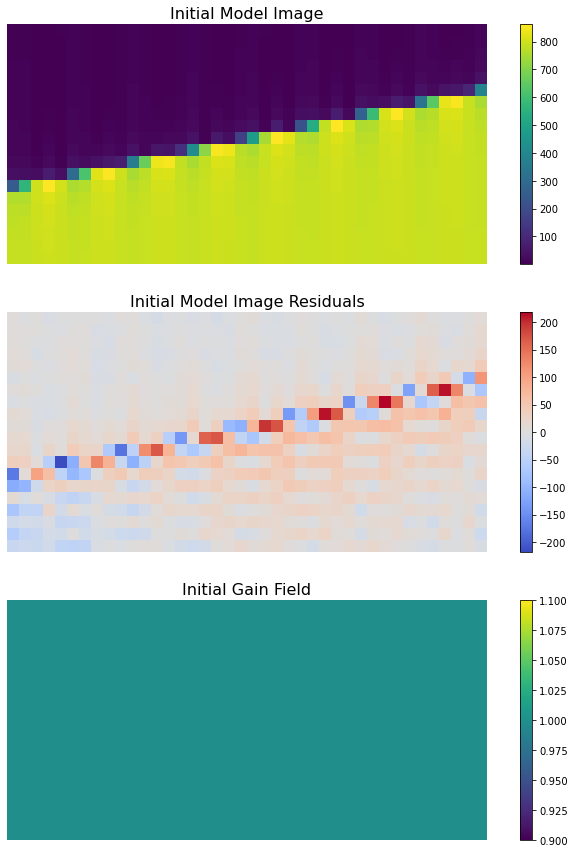

Starting parameters:
  I0 = 3.72
  I1 = 791.12
  a = 1.0
  b = 0.0
  c = 0.0
  d = 0.0
  e = 0.0
  f = 0.0
  sigma = 0.5
  intercept = 13.098150782361309
  slope = -0.2074625232519971


In [20]:
subroi = subrois['Bottom']

# Coordinate mesh
X, Y = np.meshgrid(
    np.arange(subroi.shape[1]),
    np.arange(subroi.shape[0])
)
assert X.shape == Y.shape == subroi.shape

# Starting Points for intensities from corners of image
i0_0 = subroi[:5, :5].mean() # top-left (backgound)
i1_0 = subroi[-5:, -5:].mean() # bottom-right (foreground)

# Uniform gain field
a_0 = 1.0
b_0 = c_0 = d_0 = e_0 = f_0 = 0.0

# Edge thickness (arbitrary for now)
sigma_0 = 0.5

# Edge location from edges/hough
slope_0, intercept_0 = edge_fit(subroi)

p0 = [i0_0, i1_0, a_0, b_0, c_0, d_0, e_0, f_0, sigma_0, intercept_0, slope_0]
gain = a_0 + b_0 * X + c_0 * Y + d_0 * X**2 + e_0 * Y**2 + f_0 * X*Y

# Data to fit
#subroi = subroi.copy()

subroi_initial_model = roi_model_magsi((X, Y), *p0).reshape(subroi.shape)

fig, axs = plt.subplots(3, 1, figsize=(12, 15))
img = axs[0].imshow(subroi_initial_model, cmap='viridis')
axs[0].axis('off')
axs[0].grid(False)
axs[0].set_title('Initial Model Image', fontsize=16)
fig.colorbar(img, ax=axs[0])

residuals = subroi_initial_model - subroi
img = axs[1].imshow(residuals, cmap='coolwarm', vmin=-residuals.max(), vmax=residuals.max())
axs[1].axis('off')
axs[1].grid(False)
axs[1].set_title('Initial Model Image Residuals', fontsize=16)
fig.colorbar(img, ax=axs[1])

img = axs[2].imshow(gain, cmap='viridis')
axs[2].axis('off')
axs[2].grid(False)
axs[2].set_title('Initial Gain Field', fontsize=16)
fig.colorbar(img, ax=axs[2]);

plt.show()

print('Starting parameters:')
for name, val in zip(['I0', 'I1', 'a', 'b', 'c', 'd', 'e', 'f', 'sigma', 'intercept', 'slope'], p0):
    print(f'  {name} = {val}')

Now we'll fit the model using scipy `curve_fit`. This will be the new model image.

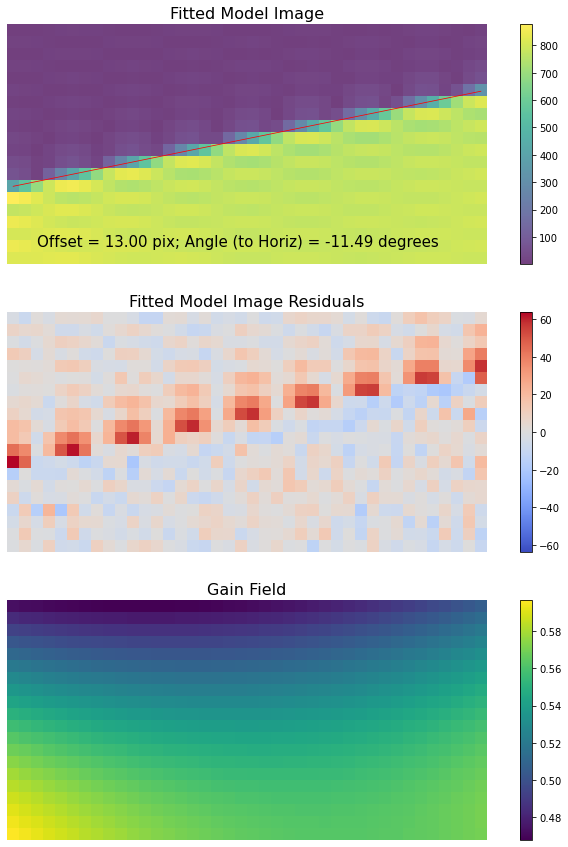

Fitted parameters:
  I0 = 11.448687181781969
  I1 = 1391.8383284535994
  a = 0.47336656842907626
  b = -0.0010201924666631322
  c = 0.01039561388172896
  d = 4.7785810727438624e-05
  e = -0.00020540503688687805
  f = -8.061061094376181e-05
  sigma = 0.9956825470400973
  intercept = 13.000744038749774
  slope = -0.20323875532207406


In [21]:
popt, pcov = curve_fit(roi_model_magsi, xdata=(X, Y), ydata=subroi.ravel(), p0=p0)
i0, i1, a, b, c, d, e, f, sigma, intercept, slope = popt

fitted_subroi = roi_model_magsi((X, Y), *popt).reshape(subroi.shape)

fig, axs = plt.subplots(3, 1, figsize=(12, 15))
img = axs[0].imshow(fitted_subroi, cmap='viridis', alpha=0.75)
axs[0].axis('off')
axs[0].grid(False)
axs[0].plot(X[0], slope*X[0] + intercept, linewidth=0.75, color='red')

angle = np.degrees(np.arctan(slope))
offset = intercept
axs[0].text(2, 18, f'Offset = {offset:0.2f} pix; Angle (to Horiz) = {angle:0.2f} degrees', fontsize=15)
axs[0].set_title('Fitted Model Image', fontsize=16)
fig.colorbar(img, ax=axs[0])


residuals = fitted_subroi - subroi
img = axs[1].imshow(residuals, cmap='coolwarm', vmin=-residuals.max(), vmax=residuals.max())
axs[1].axis('off')
axs[1].grid(False)
axs[1].set_title('Fitted Model Image Residuals', fontsize=16)
fig.colorbar(img, ax=axs[1])


# Quadratic model of bias field
gain = a + b*X + c*Y + d * X**2 + e * Y**2 + f * X*Y

img = axs[2].imshow(gain, cmap='viridis')
axs[2].axis('off')
axs[2].grid(False)
axs[2].set_title('Gain Field', fontsize=16)
fig.colorbar(img, ax=axs[2])

plt.show()

print('Fitted parameters:')
for name, val in zip(['I0', 'I1', 'a', 'b', 'c', 'd', 'e', 'f', 'sigma', 'intercept', 'slope'], popt):
    print(f'  {name} = {val}')

And the residuals now are much smaller - the fit seems pretty good but note there is still some pattern and there is a bit of a glitch at the left of the image.

In [22]:
def fit_roi_model(roi, model=roi_model_magsi):
    # Coordinates (pixels, not mm!)
    nrows, ncols = roi.shape
    X, Y = np.meshgrid(np.arange(ncols), np.arange(nrows))

    # Starting Point assume top left and bottom right  representative
    # of background and foreground
    i0_0 = roi[:5, :5].mean()
    i1_0 = roi[-5:, -5:].mean()
    a_0 = 1.0; b_0 = c_0 = d_0 = e_0 = f_0 = 0.0
    sigma_0 = 1.0

    # Use edge detected line as starting point
    slope_0, intercept_0 = edge_fit(roi)
    p0 = [i0_0, i1_0, a_0, b_0, c_0, d_0, e_0, f_0, sigma_0, intercept_0, slope_0]

    # Data to fit
    popt, pcov = curve_fit(model, xdata=(X, Y), ydata=roi.flatten(), p0=p0)
    i0, i1, a, b, c, d, e, f, sigma, intercept, slope = popt

    gain_field = a + b*X + c*Y + d * X**2 + e * Y**2 + f * X*Y
    return slope, intercept, gain_field

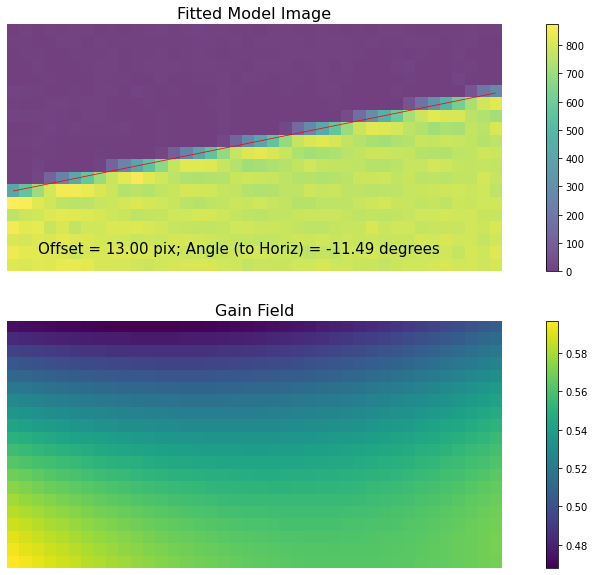

Fitted parameters:
  I0 = 11.448687181781969
  I1 = 1391.8383284535994
  a = 0.47336656842907626
  b = -0.0010201924666631322
  c = 0.01039561388172896
  d = 4.7785810727438624e-05
  e = -0.00020540503688687805
  f = -8.061061094376181e-05
  sigma = 0.9956825470400973
  intercept = 13.000744038749774
  slope = -0.20323875532207406


In [23]:
slope, intercept, gain_field = fit_roi_model(subroi)

fig, axs = plt.subplots(2, 1, figsize=(16, 10))
img = axs[0].imshow(subroi, cmap='viridis', alpha=0.75)

xx = np.arange(subroi.shape[1])
axs[0].axis('off')
axs[0].grid(False)
axs[0].plot(xx, slope*xx + intercept, linewidth=0.75, color='red')

angle = np.degrees(np.arctan(slope))
offset = intercept
axs[0].text(2, 18, f'Offset = {offset:0.2f} pix; Angle (to Horiz) = {angle:0.2f} degrees', fontsize=15)
axs[0].set_title('Fitted Model Image', fontsize=16)
fig.colorbar(img, ax=axs[0])

img = axs[1].imshow(gain, cmap='viridis')
axs[1].axis('off')
axs[1].grid(False)
axs[1].set_title('Gain Field', fontsize=16)
fig.colorbar(img, ax=axs[1])

plt.show()

print('Fitted parameters:')
for name, val in zip(['I0', 'I1', 'a', 'b', 'c', 'd', 'e', 'f', 'sigma', 'intercept', 'slope'], popt):
    print(f'  {name} = {val}')

### Intensity Normalization
The `roi_model` has given us a (quadratic) gain field - we can use that to correct for intensity variations

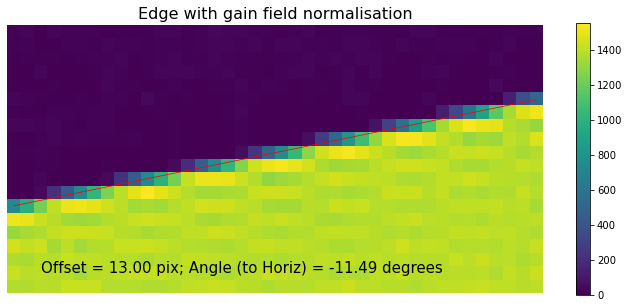

In [24]:
subroi_norm = subroi / gain
xx = np.arange(subroi_norm.shape[1])

fig = plt.figure(figsize=(12, 5))
img = plt.imshow(subroi_norm, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Edge with gain field normalisation', fontsize=16)
plt.plot(xx, slope * xx + intercept, linewidth=0.75, color='red')
plt.text(2, 18, f'Offset = {offset:0.2f} pix; Angle (to Horiz) = {angle:0.2f} degrees', fontsize=15)
fig.colorbar(img);

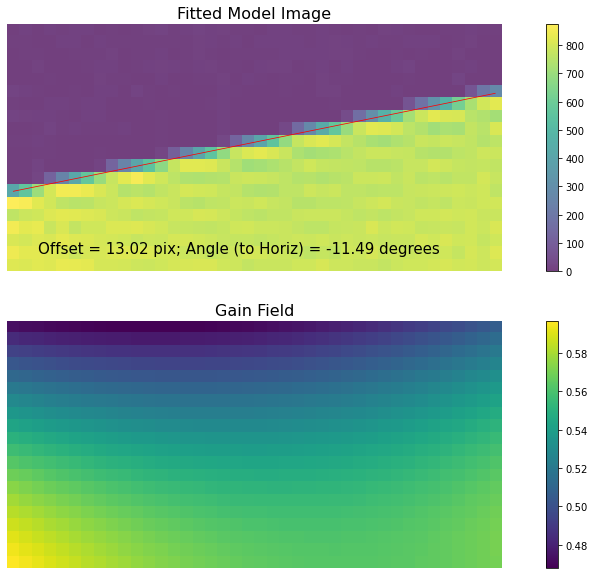

Fitted parameters:
  I0 = 11.448687181781969
  I1 = 1391.8383284535994
  a = 0.47336656842907626
  b = -0.0010201924666631322
  c = 0.01039561388172896
  d = 4.7785810727438624e-05
  e = -0.00020540503688687805
  f = -8.061061094376181e-05
  sigma = 0.9956825470400973
  intercept = 13.000744038749774
  slope = -0.20323875532207406


In [25]:
slope, intercept, gain_field = fit_roi_model(subroi, model=roi_model_erf)

fig, axs = plt.subplots(2, 1, figsize=(16, 10))
img = axs[0].imshow(subroi, cmap='viridis', alpha=0.75)

xx = np.arange(subroi.shape[1])
axs[0].axis('off')
axs[0].grid(False)
axs[0].plot(xx, slope*xx + intercept, linewidth=0.75, color='red')

angle = np.degrees(np.arctan(slope))
offset = intercept
axs[0].text(2, 18, f'Offset = {offset:0.2f} pix; Angle (to Horiz) = {angle:0.2f} degrees', fontsize=15)
axs[0].set_title('Fitted Model Image', fontsize=16)
fig.colorbar(img, ax=axs[0])

img = axs[1].imshow(gain, cmap='viridis')
axs[1].axis('off')
axs[1].grid(False)
axs[1].set_title('Gain Field', fontsize=16)
fig.colorbar(img, ax=axs[1])

plt.show()

print('Fitted parameters:')
for name, val in zip(['I0', 'I1', 'a', 'b', 'c', 'd', 'e', 'f', 'sigma', 'intercept', 'slope'], popt):
    print(f'  {name} = {val}')

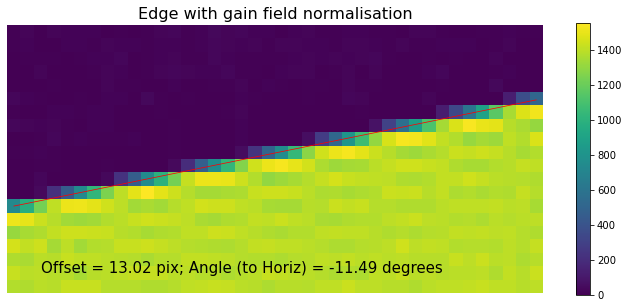

In [26]:
subroi_norm = subroi / gain
xx = np.arange(subroi_norm.shape[1])

fig = plt.figure(figsize=(12, 5))
img = plt.imshow(subroi_norm, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Edge with gain field normalisation', fontsize=16)
plt.plot(xx, slope * xx + intercept, linewidth=0.75, color='red')
plt.text(2, 18, f'Offset = {offset:0.2f} pix; Angle (to Horiz) = {angle:0.2f} degrees', fontsize=15)
fig.colorbar(img);

OK, this seems reasonable to get the edge profile from. Either the sinc or guassian seems to work OK.

### Intensities Ordered by Distance from Edge
We now  need to order the pixels by their distance from the edge.

Have a look at the pixels, just by plotting their value against their distance from the nominal edge. This may be horizontally, vertically and perpendicularly.

0.199215771212712
0.9799556502720541


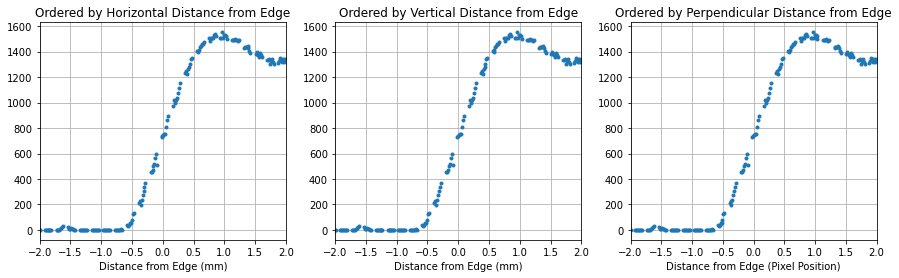

In [27]:
nrows, ncols = subroi_norm.shape

α = np.arctan(slope)

x_shifts_at_y = (np.arange(nrows) - intercept) / slope
X_shifted = (X - x_shifts_at_y[Y]).ravel()
sort_order_row = np.argsort(X_shifted)

y_shifts_at_x = np.arange(ncols) * slope + intercept
Y_shifted = (Y - y_shifts_at_x[X]).ravel()
sort_order_col = np.argsort(Y_shifted)

Perp_shifted = np.sqrt(abs(X_shifted * Y_shifted * np.sin(α) * np.cos(α) * pix_dims[0] * pix_dims[1])) * np.sign(X_shifted)
sort_order_perp = np.argsort(Perp_shifted)

pixvals = subroi_norm.ravel()

proj_factor_row = np.abs(np.sin(α))
proj_factor_col = np.abs(np.cos(α))

effective_pixel_size_row = pix_dims[1] * proj_factor_row
effective_pixel_size_col = pix_dims[0] * proj_factor_col
effective_pixel_size_proj = 1

print(proj_factor_row)
print(proj_factor_col)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(X_shifted[sort_order_row] * effective_pixel_size_row, pixvals[sort_order_row], '.')
axs[0].set_xlim(-2, 2)
axs[0].grid(True)
axs[0].set_xlabel('Distance from Edge (mm)')
axs[0].set_title('Ordered by Horizontal Distance from Edge')
axs[1].plot(Y_shifted[sort_order_col]  * effective_pixel_size_col, pixvals[sort_order_col], '.')
axs[1].set_xlim(-2, 2)
axs[1].grid(True)
axs[1].set_xlabel('Distance from Edge (mm)')
axs[1].set_title('Ordered by Vertical Distance from Edge')
axs[2].plot(Perp_shifted[sort_order_perp] * effective_pixel_size_proj, pixvals[sort_order_perp], '.')
axs[2].set_xlim(-2, 2)
axs[2].grid(True)
axs[2].set_xlabel('Distance from Edge (Pixel Position)')
axs[2].set_title('Ordered by Perpendicular Distance from Edge');

Actually, when we do it this way they all come out the same as the distance to the edge is purely geometrical and any one determines the others via some trig.

The width of the edge plotted like this seems to be just about the pixel size anyway - so we really don't seem to have any sub pixel information.

Maybe we could fit these points with a spline or low order polynomial - we really want them on a regular grid and smooth enough to differentiate.

We could try Gaussian Process Regression:
 - http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html
 - https://blog.dominodatalab.com/fitting-gaussian-process-models-python/
 - http://scikit-learn.org/stable/modules/gaussian_process.html
 - https://stackoverflow.com/questions/24978052/interpolation-over-regular-grid-in-python
 - https://en.wikipedia.org/wiki/Kriging

Alternatively, we could use lowess and interpolation.

Note also that we are dealing with *unsigned* magnitude images. This makes the edge response asymmetric as the sinc ringing (and the noise) is rectified on the left of the edge.

### Model function for the ESF
We'll have a look at a model function for the edge that takes account of the rectification. We'll base it on a model lsf composed of a sinc and a Gaussian and integrate it up for the esf.

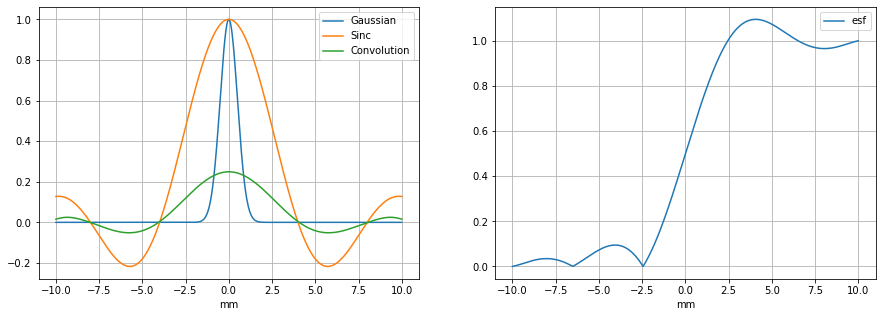

In [28]:
σ = 0.5 # width of Gaussian
w = 4 # width of Sinc
x = np.linspace(-10, 10, 2048)
dx = x[1] - x[0]
g = np.exp(-x**2 / (2*σ**2))
s = np.sinc(x/w)

# normalised convolution for "lsf"
c = np.convolve(g, s, mode='same')
c /= (c.sum() * dx)

# integral for esf, nb abs() for rectification
e = abs(cumtrapz(c, dx=x[1]-x[0], initial=0))

#e2 = erf(x / (np.sqrt(2) * σ)) * sici(x/w)[0]
#e2 = sici(x/w)[0] / np.pi
#e2 = (0.5 - si(-np.pi*x/w) / np.pi) * erf(x / (2 * σ**2))
#e2 = np.convolve(
#    0.5 - si(-np.pi*x/w) / np.pi,
#    0.5 * (1 + erf(x / (np.sqrt(2) * σ))),
#    mode='same'
#)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(x, g, label='Gaussian')
axs[0].plot(x, s, label='Sinc')
axs[0].plot(x, c, label='Convolution')
axs[0].grid(True)
axs[0].legend()
axs[0].set_xlabel('mm')

axs[1].plot(x, e, label='esf')
#axs[1].plot(x, e2, label='esf2')

axs[1].grid(True)
axs[1].set_xlabel('mm')
axs[1].legend();

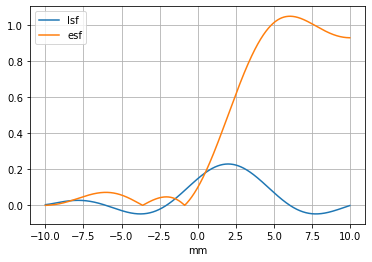

In [29]:
def lsf_model_function(x, sigma, width, centre):
    x_grid = np.linspace(x.min()-abs(centre), x.max()+abs(centre), len(x))
    dx = x_grid[1] - x_grid[0]
    g = np.exp(-x_grid**2 / (2*σ**2))
    s = np.sinc(x_grid/ w)
    c = np.convolve(g, s, mode='same')
    c /= (c.sum() * dx)
    ci = interp1d(x_grid + centre, c)
    return ci(x)

def esf_model_function(x, sigma, width, centre):
    x_grid = np.linspace(x.min()-abs(centre), x.max()+abs(centre), len(x))
    dx = x_grid[1] - x_grid[0]
    g = np.exp(-x_grid**2 / (2*σ**2))
    s = np.sinc(x_grid/ w)
    c = np.convolve(g, s, mode='same')
    c /= (c.sum() * dx)
    # abs() as we have unsigned magnitude image
    e = abs(cumtrapz(c, dx=dx, initial=0))
    ei = interp1d(x_grid + centre, e)
    return ei(x)

σ = 0.5 # width of Gaussian
w = 4 # width of Sinc
x = np.linspace(-10, 10, 2048)
l = lsf_model_function(x, σ, w, 2)
e = esf_model_function(x, σ, w, 2)
plt.plot(x, l, label='lsf')
plt.plot(x, e, label = 'esf')
plt.grid(True)
plt.xlabel('mm')
plt.legend();

### Sensitivity to angle
The edge function will be sensitive to the angle of the edge and errors in this will produce periodic patterns in the esf. We'll look at the edge data and a model fit to it for different angles.

The `empirical_esf` will be the ordered pixel values as above. The x axis will be in true *mm* rather than pixels as the pixel size is known at this point.

In [30]:
def rhs_normalised(y):
    N = 8
    return y / y[-len(y) // N:].mean()

def empirical_esf(roi, pix_dims, intercept, slope):
    """
    Unnormalised edge spread function, returned as function of displacement from edge im mm
    TODO: fix magic numbers
    """
    # Get the signed distance of each pixel (position) from the edge line
    # This is purely geometrical and it doesn't matter if we do it
    # as x distance or y distance provided we take the projected pixel size
    # into account. Here, we take the geometrical mean of two estimates of the perpendicular
    # distance - this should also work even for non-isotropic pixels.
    nrows, ncols = roi.shape
    X, Y = np.meshgrid(np.arange(ncols), np.arange(nrows))

    x_shifts_at_y = (np.arange(nrows) - intercept) / slope
    X_shifted = (X - x_shifts_at_y[Y])
    y_shifts_at_x = np.arange(ncols) * slope + intercept
    Y_shifted = (Y - y_shifts_at_x[X])

    alpha = np.arctan(slope)
    Dists_mm = np.sqrt(
        abs(X_shifted * Y_shifted * np.sin(alpha) * np.cos(alpha) * pix_dims[0] * pix_dims[1])
    ) * np.sign(X_shifted)

    x_mm = Dists_mm.ravel()
    y = roi.ravel()
    sort_indices = np.argsort(x_mm)
    x_mm, y = x_mm[sort_indices], y[sort_indices]
    
    # normalize to unity in the RHS limit, assume 0 in RHS limit
    return x_mm, rhs_normalised(y)
    

def esf_model(x_mm, sigma, width, centre, scale):
    n = len(x_mm)
    if n < 10:
        warn(f'Bad data length x_mm: {n}')
        
    if not np.all(np.isfinite(x_mm)):
        warn(f'Bad data range x_mm: ...')
        
    x_grid = np.linspace(x_mm.min()-abs(centre)-0.1, x_mm.max()+abs(centre)+0.1, n)
    dx = x_grid[1] - x_grid[0]
    #print(dx)
    assert dx > 0
    
    s = np.sinc(x_grid / width)
    assert np.all(np.isfinite(s))
    assert s.sum() > 1e-5
    
    if sigma > 0.5 * dx:
        g = np.exp(-x_grid**2 / (2*sigma**2))
        assert np.all(np.isfinite(g))
        if g.sum() > 1e-6:
            g /= g.sum()
        else:
            if (g>0).sum() > 1:
                warn(f'g has {(g>0).sum()} non-zeros when replacing by delta; sigma={sigma}')
            g = np.zeros_like(g)
            g[np.searchsorted(x_grid, 0)] = 1
    

        assert g.sum() > 1e-5
        c = np.convolve(g, s, mode='same')
        assert np.all(np.isfinite(c))
        assert c.sum() > 1e-5
    
        c /= (c.sum() * dx)
        assert np.all(np.isfinite(c))
    else:
        c = s / (s.sum() * dx)

    e = cumtrapz(c, dx=dx, initial=0)
    assert np.all(np.isfinite(e))

    ei = interp1d(x_grid + centre, e)
    if not np.all(np.isfinite(ei(x_mm))):
        warn(f'Bad model params: sigma: {sigma}, width: {width}, centre: {centre}, scale: {scale}')
    return ei(x_mm) * scale


def esf_model_abs(x_mm, sigma, width, centre, scale):
    return abs(
        esf_model(x_mm, sigma, width, centre, scale)
    )


def fit_esf_model(x_mm, y, pix_sz_mm):
    """
        TODO: fix magic numbers
    """

    # looks like it's very sensitive to the starting point for sinc width
    # we don't know the pixel size at this point though (can we pass in?)
    #       (mm)    sigma  width centre scale
    #lower_bounds = (0.005, 0.1, -1,     0.9)
    #start_points = (0.05,  1.0,  0,     1.0)
    #upper_bounds = (0.2,   5.0,  1,     1.1)
    lower_bounds = (0.001*pix_sz_mm, 0.25*pix_sz_mm, -1,     0.9)
    start_points = (0.05*pix_sz_mm,  pix_sz_mm,  0,     1.0)
    upper_bounds = (0.2*pix_sz_mm,   4*pix_sz_mm,  1,     1.1)    
    popt, _ = curve_fit(
        esf_model_abs,
        x_mm, y,
        p0=start_points,
        bounds=(lower_bounds, upper_bounds),
        method='dogbox',
        loss='soft_l1'
    )
    return popt

def fitted_esf(x_mm, y, pix_sz_mm):
    sigma_opt, width_opt, centre_opt, scale_opt = fit_esf_model(x_mm, y, pix_sz_mm)
    return esf_model(x_mm, sigma_opt, width_opt, centre_opt, scale_opt)

def fitted_esf_abs(x_mm, y, pix_sz_mm):
    return abs(fitted_esf(x_mm, y, pix_sz_mm))

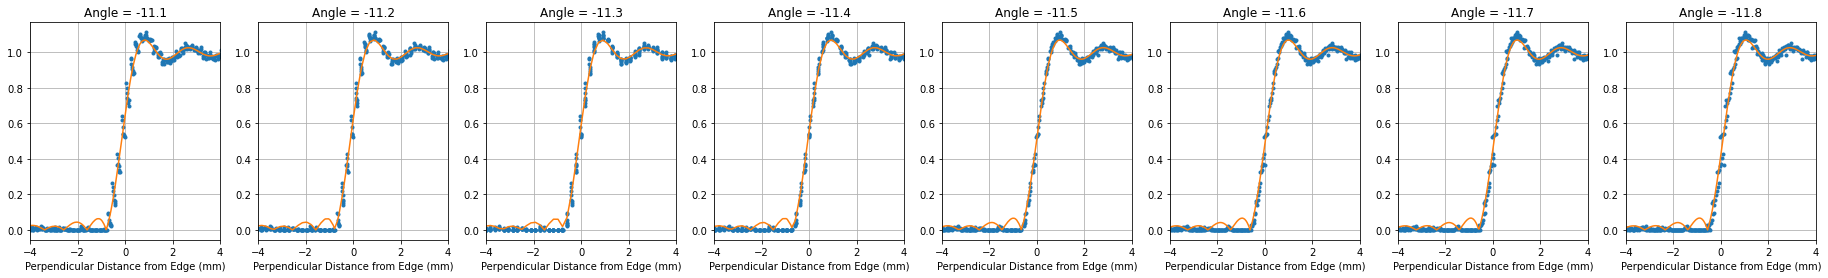

In [31]:
angles = [-11.1, -11.2, -11.3, -11.4, -11.5, -11.6, -11.7, -11.8]
fig, axs = plt.subplots(1, len(angles), figsize=(4*len(angles), 4))
for ax, angle in zip(axs, angles):
    x_mm, y = empirical_esf(subroi_norm, pix_dims, intercept, np.tan(np.radians(angle)))
    sigma_opt, width_opt, centre_opt, scale_opt = fit_esf_model(x_mm, y, pix_sz_mm=pix_dims[0])
    yfit = esf_model_abs(x_mm, sigma_opt, width_opt, centre_opt, scale_opt)
    #print(sigma_opt, width_opt, centre_opt, scale_opt)
    #yfit = fitted_esf_abs(x_mm, y)
    ax.plot(x_mm, y, '.')
    ax.set_xlim(-4, 4)
    ax.plot(x_mm, yfit)
    ax.grid(True)
    ax.set_xlabel('Perpendicular Distance from Edge (mm)')
    ax.set_title(f'Angle = {angle}');

This is incredibly sensitive: if we are out by only about 0.2 degrees this is enough to really mess up the curve. We'll need to adjust the slope in some sort of optimisation. It seems difficult to do this in a model free way based on the "entropy" or high frequency content of the curve, so we'll have a look at the residuals after fitting the model. It produces a much nicer minumum if we look only at the central part rather than including the oscillations..

### Use the quality of the ESF fit to refine the angle
Try using the residuals from fitting the esf as a measure of how well aligned the edge is.

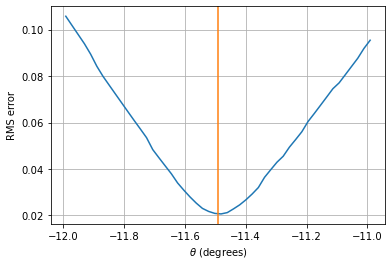

In [33]:
alpha = np.degrees(np.arctan(slope))
angles= np.linspace(alpha-0.5, alpha+0.5, 50)

residuals = []
for angle in angles:
    x_mm, y = empirical_esf(subroi_norm, pix_dims, intercept, np.tan(np.radians(angle)))
    yfit = fitted_esf_abs(x_mm, y, pix_dims[0])
    # central part only
    ystart = np.nonzero(yfit > 0.2)[0][0]
    ystop = np.nonzero(yfit > 0.8)[0][0]
    residuals.append(
        np.sqrt(
            ((y-yfit)[ystart: ystop]**2).mean()
        )
    )

plt.plot(angles, residuals)
plt.axvline(alpha, color='C1')
plt.grid(True)
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel('RMS error');

# NB: can break down if we go to larger differences from the optimum angle

We can use this as a way of refining the angle obtained previously, but note that:
 - the fit is brittle and for some angles, especially away from the true alignment it fails entirely
 - we only get a reasonably convex minimum if we restrict the penalty to the centre of the curve
   - there are some magic numbers to determine this

In [35]:
def edge_angle_opt_fun(angle, roi_norm, pix_dims, intercept):
    x_mm, y = empirical_esf(roi_norm, pix_dims, intercept, np.tan(np.radians(angle)))
    yfit = fitted_esf_abs(x_mm, y, pix_dims[0])
    ystart = np.nonzero(yfit > 0.2)[0][0]
    ystop = np.nonzero(yfit > 0.8)[0][0]
    return np.sqrt(
        ((y - yfit)[ystart: ystop]**2).mean()
    )

def refine_edge_angle(angle_0, roi_norm, pix_dims, intercept, delta=0.75):
    return minimize_scalar(
        fun=edge_angle_opt_fun,
        bounds=(angle_0 - delta , angle_0 + delta),
        args=(roi_norm, pix_dims, intercept),
        method='Bounded'
    ).x

angle_0 = np.degrees(np.arctan(slope))
angle_opt = refine_edge_angle(angle_0, subroi_norm, pix_dims, intercept)
slope_opt = np.tan(np.radians(angle_opt))
print(f'Initialangle = {angle_0:0.4f}, Optimised angle = {angle_opt:0.4f}')

Initialangle = -11.4911, Optimised angle = -11.4861


### Analysis based on fitted function

We could also use this model fit to extract an *analytic* edge function rather than trying to smooth the data in the emprical esf.

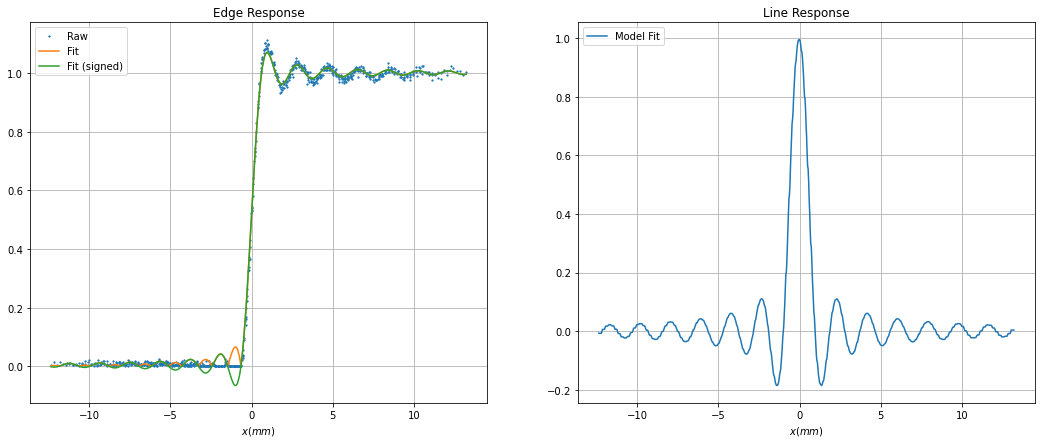

In [37]:
x, y = empirical_esf(subroi_norm, pix_dims, intercept, slope_opt)
yfit_signed = fitted_esf(x, y, pix_dims[0])
yfit_abs = fitted_esf_abs(x, y, pix_dims[0])

x_grid = np.linspace(x.min(), x.max(), len(x))
y_grid = interp1d(x, yfit)(x_grid) 
y_grid_signed = interp1d(x, yfit_signed)(x_grid) 
dx = x_grid[1] - x_grid[0]
lsf_fit = np.gradient(y_grid_signed, dx)

_, axs = plt.subplots(1, 2, figsize=(18, 7))
axs[0].plot(x, y, '.', markersize=2.5, label='Raw')
axs[0].plot(x, yfit_abs, label='Fit')
axs[0].plot(x, yfit_signed, label='Fit (signed)')

axs[0].set_xlabel('$x (mm)$')
axs[0].legend(loc='upper left')
axs[0].grid(True)
axs[0].set_title('Edge Response')

# really want fit functon without abs() for symmetric line reponse  
#axs[1].plot(x, np.gradient(y, x), label='Raw')
axs[1].plot(x_grid, lsf_fit, label='Model Fit')
axs[1].set_xlabel('$x (mm)$')
axs[1].legend(loc='upper left')
axs[1].set_title('Line Response')

axs[1].grid(True)

Real Pixel Size: 0.97 mm
Line Response Length: 800 (-12.36 -> 13.20) mm
MTF (50) = 0.52 lp/mm


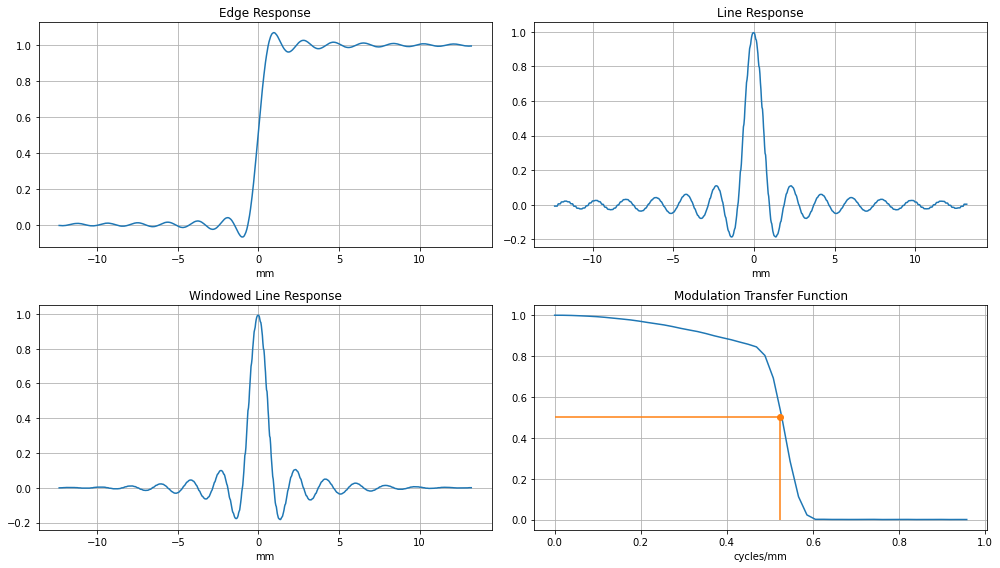

In [38]:
x, y = empirical_esf(subroi_norm, pix_dims, intercept, slope_opt)
yfit_signed = fitted_esf(x, y, pix_dims[0])
yfit_abs = fitted_esf_abs(x, y, pix_dims[0])

x_grid = np.linspace(x.min(), x.max(), len(x))
y_grid = interp1d(x, yfit)(x_grid) 
y_grid_signed = interp1d(x, yfit_signed)(x_grid) 
dx = x_grid[1] - x_grid[0]
lsf_fit = np.gradient(y_grid_signed, dx)

################

edge_response = y_grid_signed
line_response = lsf_fit
windowed_line_response = line_response * hamming(len(lsf_fit)) # we should make sure it is centred on zero first

npoints = len(line_response)

# Normalized to maximum at DC
# zero fill by factor 2:  mtf will ave same no. of points as lsf
padded_line_reponse =  np.pad(windowed_line_response, npoints//2, mode='constant')
npoints_padded = len(padded_line_reponse)
assert npoints_padded == 2 * npoints

# Real FFT
mtf = np.abs(rfft(padded_line_reponse))
assert mtf.argmax() == 0
mtf /= mtf[0]
# trim aliased point at end mtf
mtf = mtf[:-1]
if npoints % 2:
    assert len(mtf) == npoints - 1
else:
    assert len(mtf) == npoints

# Check this - we are working in mm
x_mtf = fftfreq(npoints_padded, dx)[:len(mtf)]

assert len(mtf) == len(x_mtf)

fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.ravel()

axs[0].plot(x_grid, edge_response)
axs[0].set_title('Edge Response')
axs[0].set_xlabel('mm')
axs[0].grid(True)

axs[1].plot(x_grid, line_response)
axs[1].set_title('Line Response')
axs[1].set_xlabel('mm')
axs[1].grid(True);

axs[2].plot(x_grid, windowed_line_response)
axs[2].set_title('Windowed Line Response')
axs[2].set_xlabel('mm')
axs[2].grid(True)

axs[3].plot(x_mtf[:50], mtf[:50])
axs[3].set_title('Modulation Transfer Function')
axs[3].set_xlabel('cycles/mm')
axs[3].grid(True)

# need to interpolate to get 50% point as too few points
x_mtf_interp = np.linspace(x_mtf[0], x_mtf[50], 100)
mtf_interp = interp1d(x_mtf[:51], mtf[:51])(x_mtf_interp)
halfmax = x_mtf_interp[abs(mtf_interp - 0.5).argmin()]
axs[3].vlines(halfmax, 0, 0.5, color='C1')
axs[3].hlines(0.5, 0, halfmax, color='C1')
axs[3].plot(halfmax, 0.5, 'o')

plt.tight_layout()

print(f'Real Pixel Size: {pix_dims[1]:0.2f} mm')
print(f'Line Response Length: {len(line_response)} ({x_grid[0]:0.2f} -> {x_grid[-1]:0.2f}) mm')
print(f'MTF (50) = {halfmax:0.2f} lp/mm')

### Lowess Smoothing and Regridding
OK, Let's try a lowess, followed by interpolation onto a grid. We'll use the *optimised* edge  angle and row distances for now.

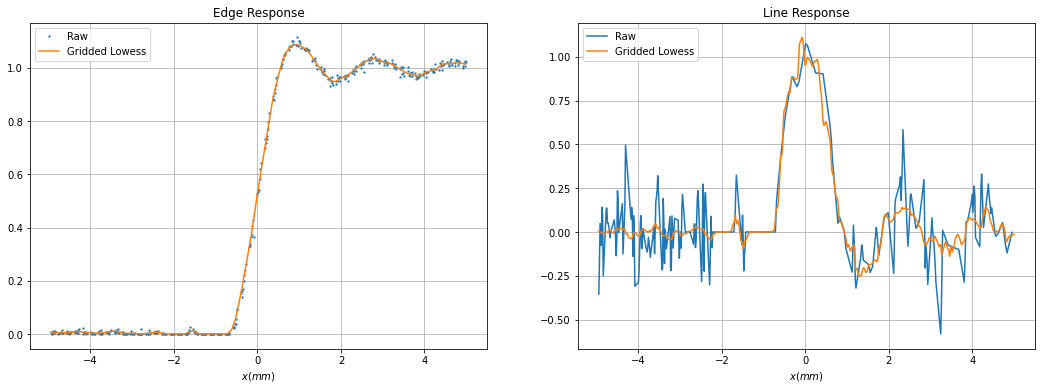

In [39]:
x, y = empirical_esf(subroi_norm, pix_dims, intercept, slope_opt)
#n = len(y)
#y /= y[7*n//8:].mean()

# Trim down to +/- 5 mm
central_region = (-5 < x) & (x < 5)
x = x[central_region]
y = y[central_region]

# seems very sensitive to this: 10 -> very noisy; 15 -> underfitting, had 10 before but doesn't seem to work very well with 256^2 images
npoints = 13

# Lowess fit on irregular grid
assert(list(x) == sorted(x))
w = lowess(y, x, frac=npoints/len(x), return_sorted=False)

# Interpolate onto regular grid
# nb the 512 here is a magic number ...
f = interp1d(x, w, kind='cubic')
x_grid = np.linspace(x.min(), x.max(), 512)
dx_grid = x_grid[1]-x_grid[0]
w_grid = f(x_grid)

_, axs = plt.subplots(1, 2, figsize=(18, 6))
axs[0].plot(x, y, '.', markersize=2.5, label='Raw')
axs[0].plot(x_grid, w_grid, label='Gridded Lowess')
axs[0].set_xlabel('$x (mm)$')
axs[0].legend(loc='upper left')
axs[0].grid(True)
axs[0].set_title('Edge Response')

outliers = abs(y - w) > 0.005
x_clean, y_clean = x[~outliers], y[~outliers]
axs[1].plot(x_clean, np.gradient(y_clean, x_clean), label='Raw')
axs[1].plot(x_grid, np.gradient(w_grid, dx_grid), label='Gridded Lowess')
axs[1].set_xlabel('$x (mm)$')
axs[1].legend(loc='upper left')
axs[1].set_title('Line Response')

axs[1].grid(True)

### Line response and MTF

Real Pixel Size: 0.97 mm
Line Response Length: 512
MTF (50) = 0.55 lp/mm


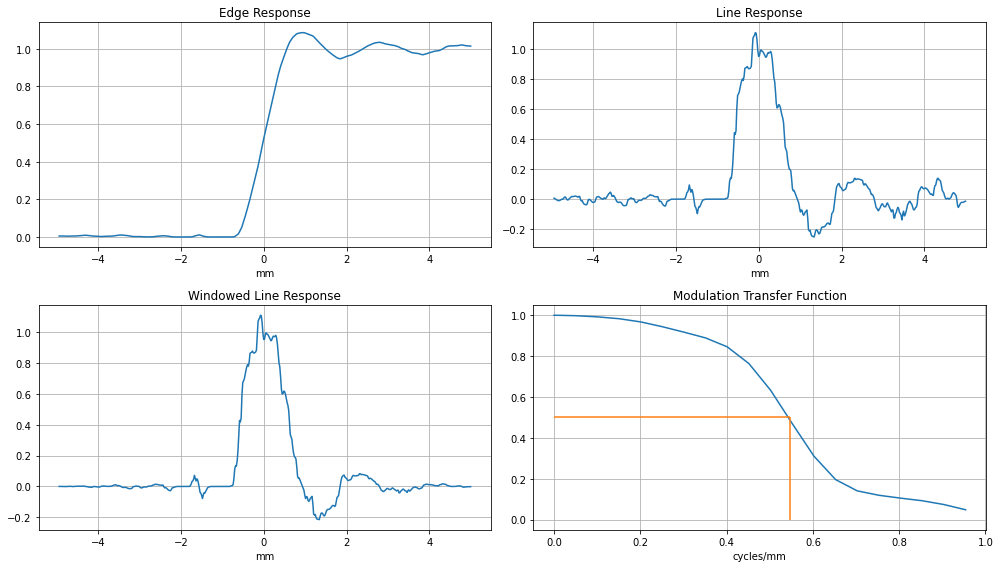

In [40]:
from scipy.signal import hamming
from numpy.fft import rfft, fftshift, fft

esf = w_grid
lsf = np.gradient(esf, dx_grid)
windowed_lsf = lsf * hamming(len(lsf))
effective_pixel_size = dx_grid

#pk_ind = np.argmax(lsf)

#del pk_ind

npoints = len(windowed_lsf)

padded_lsf =  np.pad(windowed_lsf, npoints//2, mode='constant')
npoints_padded = len(padded_lsf)
assert npoints_padded == 2 * npoints

# Real FFT
mtf = np.abs(rfft(padded_lsf))
assert mtf.argmax() == 0
mtf /= mtf[0]
# trim aliased point at end mtf
mtf = mtf[:-1]
assert len(mtf) == npoints

# Check this - we are working in mm
x_mtf = fftfreq(npoints_padded, dx_grid)[:len(mtf)]
assert len(mtf) == len(x_mtf)


fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.ravel()

#x_axis_edge = (np.arange(len(edge_response)) - pk_ind) * effective_pixel_size
#axs[0].plot(x_axis_edge, edge_response)
axs[0].plot(x_grid, esf)
axs[0].set_title('Edge Response')
axs[0].set_xlabel('mm')
axs[0].grid(True)

#x_axis_line = (np.arange(len(line_response)) - pk_ind) * effective_pixel_size
#axs[1].plot(x_axis_line, line_response)
axs[1].plot(x_grid, lsf)
axs[1].set_title('Line Response')
axs[1].set_xlabel('mm')
axs[1].grid(True);

#axs[2].plot(x_axis_line, windowed_line_response)
axs[2].plot(x_grid, windowed_lsf)
axs[2].set_title('Windowed Line Response')
axs[2].set_xlabel('mm')
axs[2].grid(True)

axs[3].plot(x_mtf[:20], mtf[:20])
axs[3].set_title('Modulation Transfer Function')
axs[3].set_xlabel('cycles/mm')
axs[3].grid(True)
# need to interpolate to get 50% point as too few points
x_mtf_interp = np.linspace(x_mtf[0], x_mtf[20], 100)
mtf_interp = interp1d(x_mtf[:21], mtf[:21])(x_mtf_interp)
halfmax = x_mtf_interp[(abs(mtf_interp - 0.5)).argmin()]
axs[3].vlines(halfmax, 0, 0.5, color='C1')
axs[3].hlines(0.5, 0, halfmax, color='C1')

plt.tight_layout()

print(f'Real Pixel Size: {pix_dims[1]:0.2f} mm')
print(f'Line Response Length: {len(lsf)}')
print(f'MTF (50) = {halfmax:0.2f} lp/mm')

Still TODO:
 - Check definition of parameters from MTF
 - FWHM of line response
 - Identify 4 edges from general region (peaks in Hough Line Transform?)
 - Rule for trimming line segments
 - Combination of individual curves - how to register? around peak in line response?
 - Do we separate out (near) horizonatal and vertical edges
 - Check sensitivity of paramaters
 - Can we determine inclinations jointly?
   - Could fit whole block with model but what about the rounded corners?

OK, we just need to sort out the order of the lines and edges.

for each line:
    decide whether it is horizontal or vertical
    find two lines of opposite type
    for horizontal lines select horiz rectangle
    for vertical lines select vertical rectangle and transpose
    if brightness decreasing with y flip ud

Then we'll have four equivalent edges - alternatively keep horiz and vert separate - OK do that initially

In [41]:
def esf_from_roi(roi, pix_dims):
    """
    Return *irregularly* sampled edge response in terms of mm.
    
    Assumes the edge appears approximately horizontal in ROI, rising left to right and bright at the bottom.
    """
    # use model of image to get first refinement of angle
    # NB this is in *pixels*
    slope, intercept, gain_field = fit_roi_model(roi)
    roi_norm = roi / gain_field
    
    # slope and intercept are in pixels:
    # use model of esf to get second refinement of slope if edge is coarse
    """
    if pix_dims[0] > 0.75: 
        angle_0 = np.degrees(np.arctan(slope))
        angle_opt = refine_edge_angle(
            angle_0,
            roi_norm,
            pix_dims,
            intercept # in *pixel* coords
        )
        #print(f'{angle_0:0.2f} -> {angle_opt:0.2f}')
        slope = np.tan(np.radians(angle_opt))
    """
    x_mm, y = empirical_esf(roi_norm, pix_dims, intercept, slope)
    
    #print(f'esf_from_roi (1): {len(x_mm)} {len(y)}')

    # Normalise to unit range on assumption that it tends to zero and one at left and right ends

    #print(f'esf_from_roi (2): {len(x_mm)} {len(y)}')
    return x_mm, y


def lowess_regrid(x_mm, y, window=10):
    """
    """
    window = 12
    # Assumed irregular (in mm) but monotonically increasing (ie sorted)
    assert np.all(np.diff(x_mm) >= 0)

    # Trim down to +/- 1.75 mm (arbitrary?)
    #vals_at_locns = vals_at_locns[(-1.75 < locns_mm) & ((locns_mm < 1.75))]
    #locns_mm = locns_mm[(-1.75 < locns_mm) & ((locns_mm < 1.75))]
    #x = locns_mm
    #y = vals_at_locns - vals_at_locns.mean()

    # Lowess fit on irregular grid
    npoints = len(x_mm)
    w = lowess(y, x_mm, frac=window/npoints, return_sorted=False)

    # Interpolate result onto a regular grid
    # TODO: do we use the same number of points or fix a length?
    #return x_grid, w_grid + vals_at_locns.mean()

    x_grid = np.linspace(x_mm.min(), x_mm.max(), 2048)
    return x_grid, interp1d(x_mm, w, kind='quadratic')(x_grid)


def lsf_from_esf(x_mm, esf):
    """
    Windowed line spread function from edge spread function
    """
    # assumes esf is on equally spaced grid
    assert np.ptp(np.diff(x_mm)) < 1e-2
    assert esf.shape == x_mm.shape

    dx = x_mm[1] - x_mm[0]
    lsf = np.gradient(esf, dx)
    return lsf * hamming(len(lsf))


def msf_from_lsf(x_mm, lsf):
    # assumes ls is on equally spaced grid
    assert np.ptp(np.diff(x_mm)) < 1e-2
    assert lsf.shape == x_mm.shape
    dx = x_mm[1] - x_mm[0]

    # Zero fill so when we do an rfft we end up with as meany points as before
    npoints = len(lsf)
    padded_lsf =  np.pad(lsf, npoints//2, mode='constant')
    npadded = len(padded_lsf)
    assert npadded == (2 * npoints) if npoints % 2 else (2 * npoints - 1)
    
    # Real FFT, trim aliased point at end of rfft
    mtf = np.abs(rfft(padded_lsf))
    if mtf.argmax() != 0:
        warn('MTF maximum is not at zero')
    mtf /= mtf[0]

    mtf = mtf[:-1]
    assert len(mtf) == (npoints - 1) if npoints % 2 else npoints

    # Check this - we are working in mm
    x_mtf = fftfreq(npadded, dx)[:len(mtf)]
    return x_mtf, mtf

### Look at each edge separately
#### Angle Sensitivity

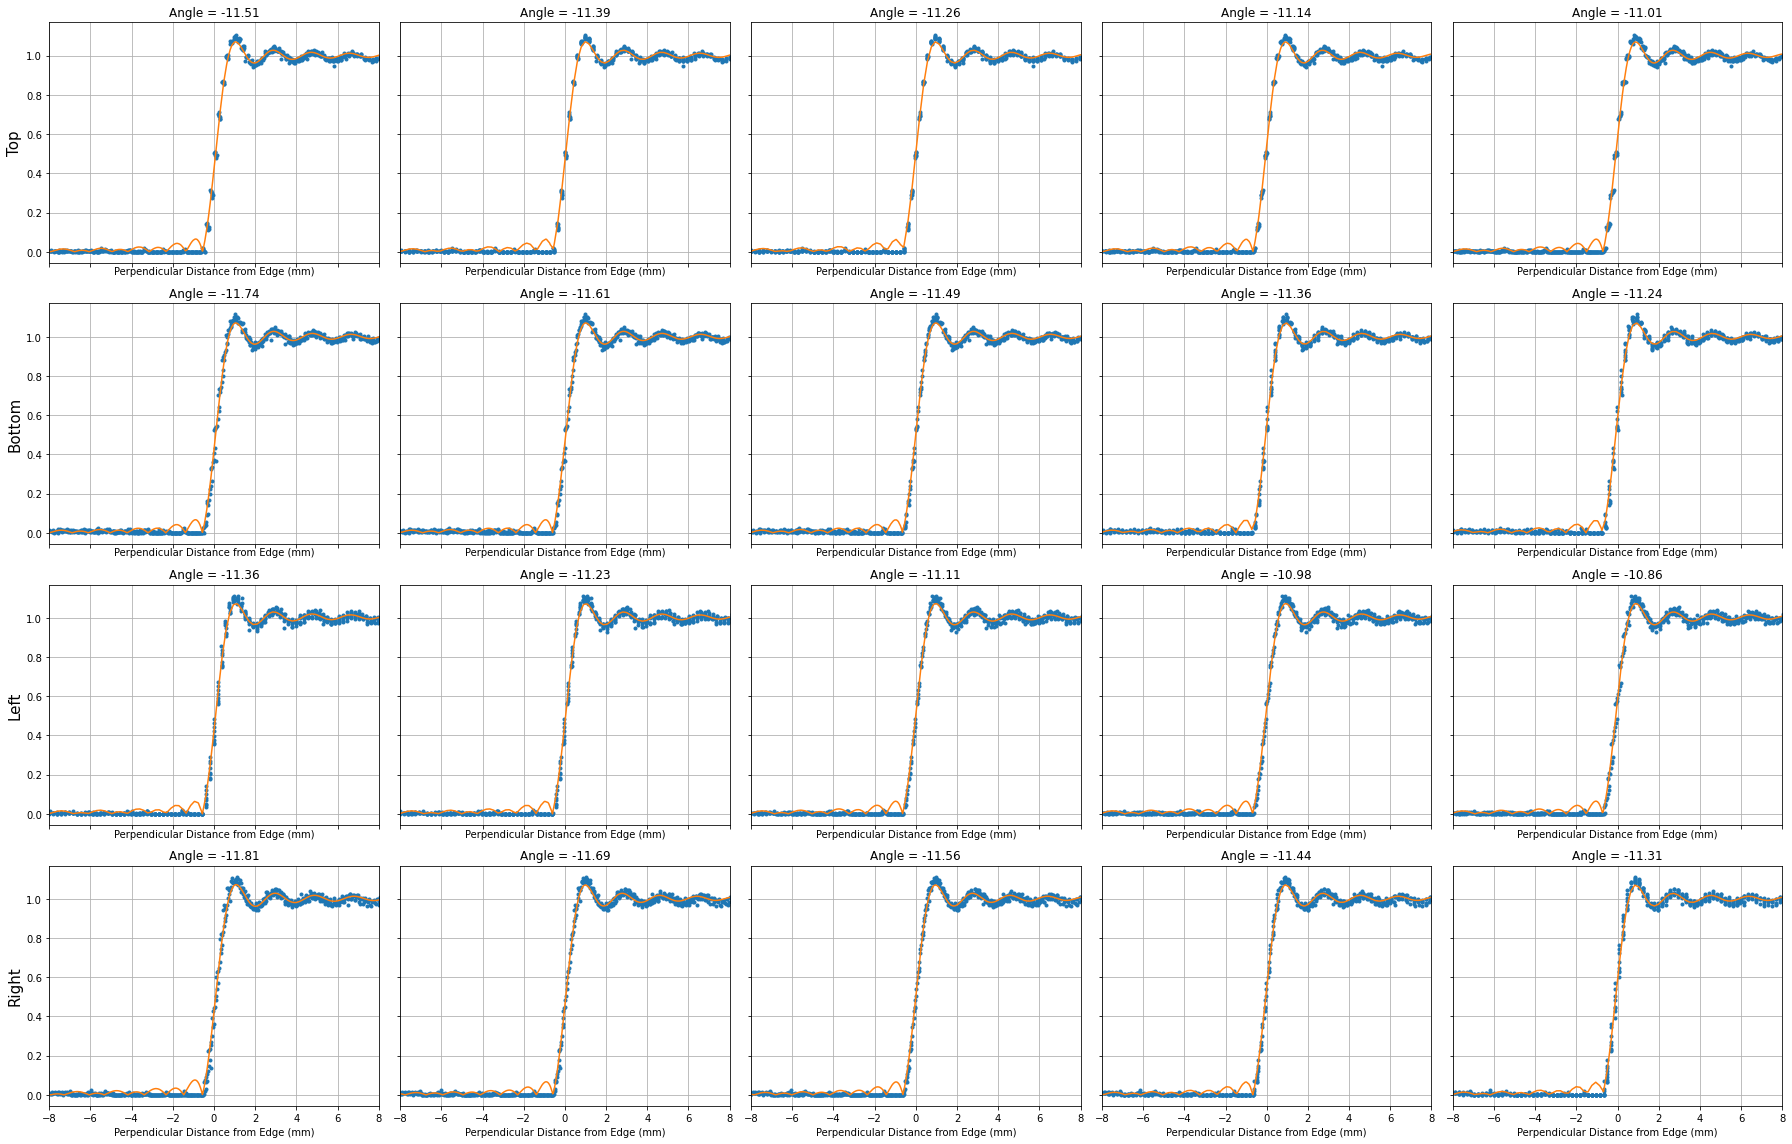

In [43]:
nangles = 5
nrois = 4
pix_dims = pix_spacing_yx(dobj)

fig, axs = plt.subplots(4, nangles, figsize=(5*nangles, 4*nrois), sharex=True, sharey=True)

for i, roiname in enumerate(['Top', 'Bottom', 'Left', 'Right']):
    subroi = subrois[roiname]
    ny, nx = subroi.shape
    slope, intercept, gain = fit_roi_model(subroi)
    alpha_0 = np.degrees(np.arctan(slope))
    angles = np.linspace(alpha_0 - 0.25, alpha_0 + 0.25, nangles)

    for j, (ax, angle) in enumerate(zip(axs[i], angles), 1):
        x_mm, y = empirical_esf(subroi/gain, pix_dims, intercept, np.tan(np.radians(angle)))
        np.save(f'esf/lores-{roiname}-{j:02d}-x', x_mm)
        np.save(f'esf/lores-{roiname}-{j:02d}-y', y)

        yfit = fitted_esf_abs(x_mm, y, pix_dims[0])
        ax.plot(x_mm, y, '.')
        ax.set_xlim(-8, 8)
        ax.plot(x_mm, yfit)
        ax.grid(True)
        ax.set_xlabel('Perpendicular Distance from Edge (mm)')
        ax.set_title(f'Angle = {angle:0.2f}')
    axs[i][0].set_ylabel(roiname, fontsize=15)
plt.tight_layout()

#### Angle optimization shape

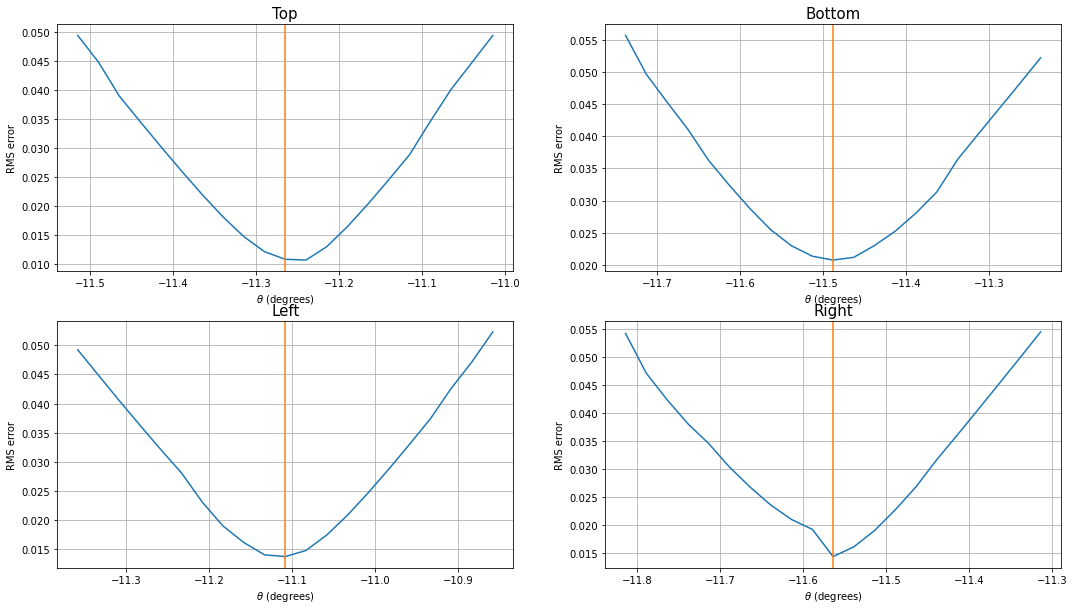

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
for ax, roiname in zip(axs.flat, ['Top', 'Bottom', 'Left', 'Right']):
    subroi = subrois[roiname]
    ny, nx = subroi.shape
    slope, intercept, gain = fit_roi_model(subroi)
    alpha_0 = np.degrees(np.arctan(slope))
    angles = np.linspace(alpha_0 - 0.25, alpha_0 + 0.25, 21)

    residuals = []
    for angle in angles:
        x_mm, y = empirical_esf(subroi/gain, pix_dims, intercept, np.tan(np.radians(angle)))
        yfit = fitted_esf_abs(x_mm, y, pix_dims[0])
    
        # central part only
        if len(np.nonzero(yfit > 0.2)[0]) < 1:
            dump = yfit.copy()
        ystart = np.nonzero(yfit > 0.2)[0][0]
        ystop = np.nonzero(yfit > 0.8)[0][0]
        residuals.append(
            np.sqrt(
                    ((y-yfit)[ystart: ystop]**2).mean()
            )
        )

    ax.plot(angles, residuals)
    ax.grid(True)
    ax.set_xlabel(r'$\theta$ (degrees)')
    ax.set_ylabel('RMS error')
    ax.set_title(roiname, fontsize=15)
    ax.axvline(alpha_0, color='C1')

# NB: can break down if we go to larger diffeences from the optimum angle
# WTF? why are the residuals minimum at exactly the starting point even though it is wrong?

#### Fitted edges with refined angles

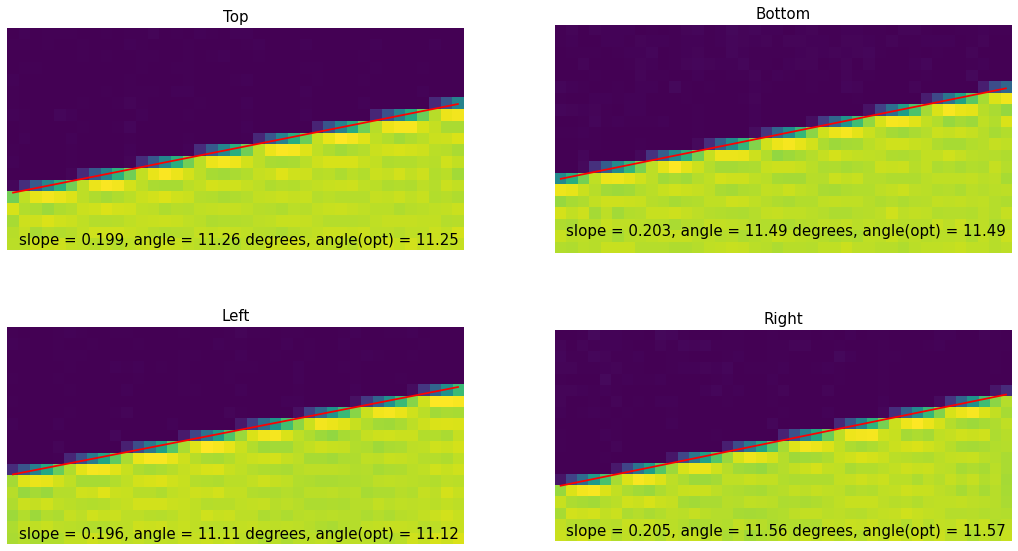

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
for ax, roiname in zip(axs.flat, ['Top', 'Bottom', 'Left', 'Right']):
    subroi = subrois[roiname]
    ny, nx = subroi.shape
    slope, intercept, gain = fit_roi_model(subroi)
    
    angle_0 = np.degrees(np.arctan(slope))
    angle_opt = refine_edge_angle(angle_0, subroi / gain, pix_dims, intercept)    
    ax.imshow(subroi/gain)
    ax.plot(np.arange(nx), np.arange(nx)*slope + intercept, linewidth=1.75, color='red')
    ax.axis(False)
    ax.set_title(roiname, fontsize=15)
    ax.text(0.5, 18, f'slope = {-slope:0.3f}, angle = {-angle_0:0.2f} degrees, angle(opt) = {-angle_opt:0.2f} ', fontsize=15)

#### ESF with Lowess
##### With and without sign correction

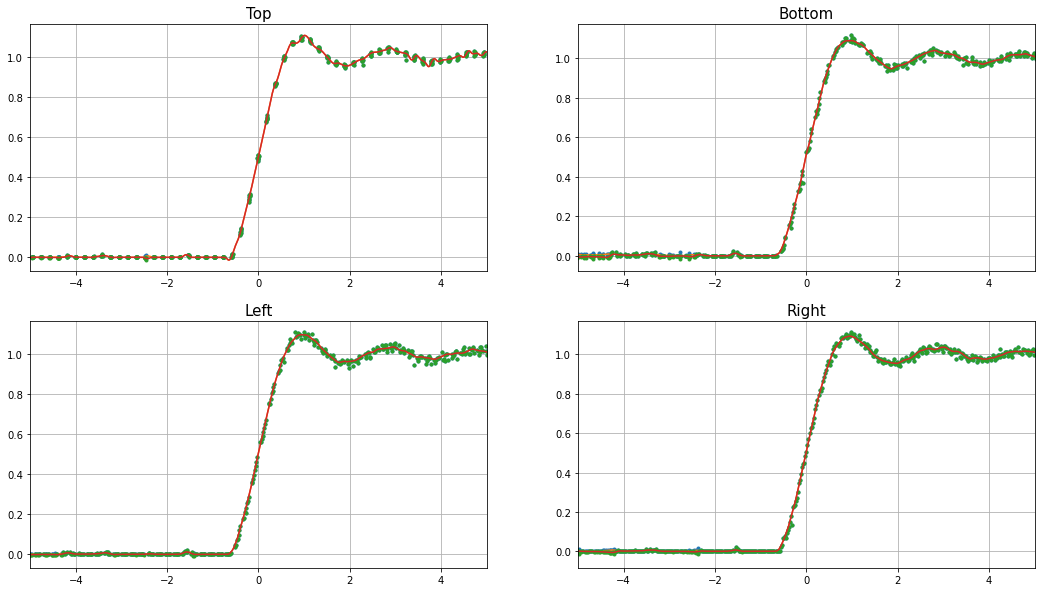

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
for ax, roiname in zip(axs.flat, ['Top', 'Bottom', 'Left', 'Right']):
    subroi = subrois[roiname]
    x_mm, esf = esf_from_roi(subroi, pix_dims)
    np.save(f'{roiname}.npy', np.column_stack([x_mm, esf]))
    x_mm_grid, esf_grid = lowess_regrid(x_mm, esf)
    ax.plot(x_mm, esf, '.')
    ax.plot(x_mm_grid, esf_grid)
    
    esf_signed = esf * np.sign(fitted_esf(x_mm, esf, pix_dims[0]))
    x_mm_grid, esf_signed_grid = lowess_regrid(x_mm, esf_signed)
    ax.plot(x_mm, esf_signed, '.')
    ax.plot(x_mm_grid, esf_signed_grid)
    
    ax.set_xlim(-5, 5)
    ax.grid(True)
    ax.set_title(roiname, fontsize=15)

#### ESF with Model
##### With and without sign correction

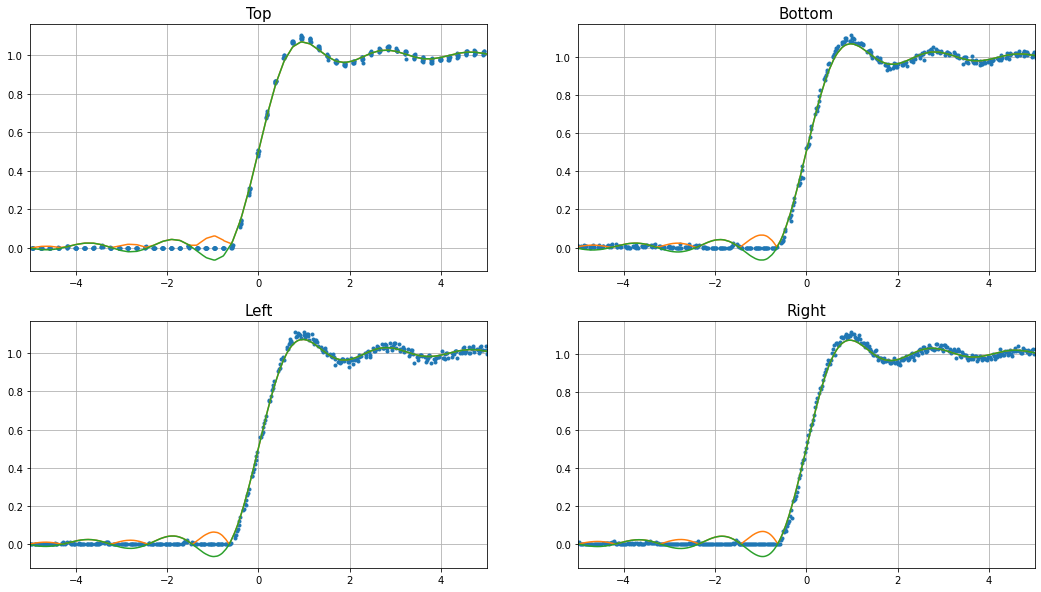

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
for ax, roiname in zip(axs.flat, ['Top', 'Bottom', 'Left', 'Right']):
    subroi = subrois[roiname]
    x_mm, esf = esf_from_roi(subroi, pix_dims)
    esf_fitted = fitted_esf_abs(x_mm, esf, pix_dims[0])
    x_mm_grid = np.linspace(x_mm.min(), x_mm.max(), 2048)
    esf_grid = interp1d(x_mm, esf_fitted)(x_mm_grid)

    esf_signed = fitted_esf(x_mm, esf, pix_dims[0])
    esf_signed_grid = interp1d(x_mm, esf_signed)(x_mm_grid)

    ax.plot(x_mm, esf, '.')
    ax.plot(x_mm_grid, esf_grid)
    ax.plot(x_mm_grid, esf_signed_grid)

    ax.set_xlim(-5, 5)
    ax.grid(True)
    ax.set_title(roiname, fontsize=15)

#### LSF with Lowess
##### With and without sign correction

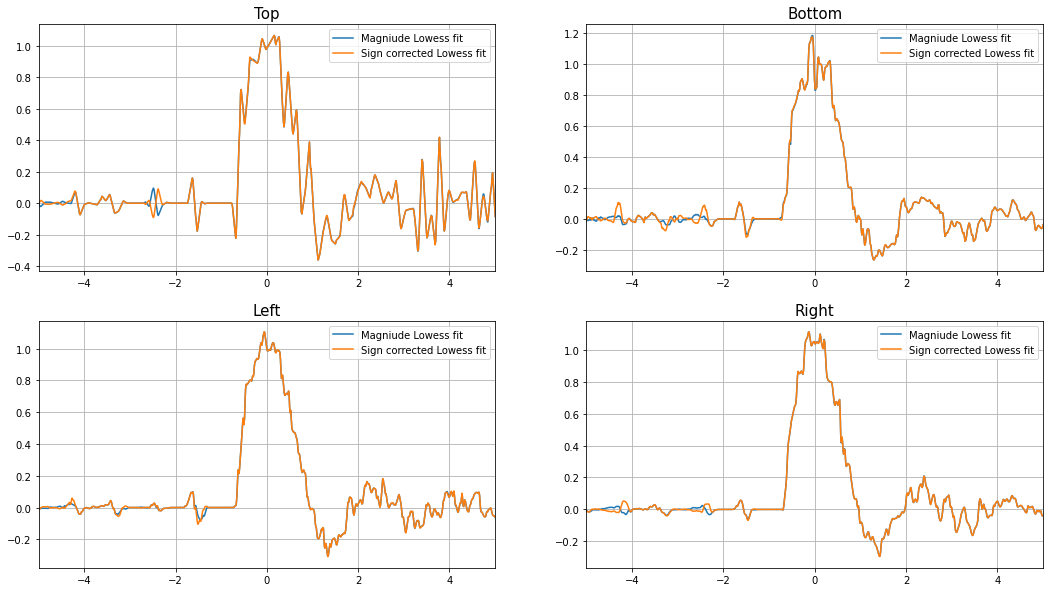

In [54]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
for ax, roiname in zip(axs.flat, ['Top', 'Bottom', 'Left', 'Right']):
    subroi = subrois[roiname]
    ny, nx = subroi.shape
    #slope, intercept, gain = fit_roi_model(subroi)
    x_mm, esf = esf_from_roi(subroi, pix_dims)
    
    x_mm_grid, esf_grid = lowess_regrid(x_mm, esf)
    lsf_grid = lsf_from_esf(x_mm_grid, esf_grid)
    ax.plot(x_mm_grid, lsf_grid, label='Magniude Lowess fit')
    
    esf_signed = esf * np.sign(fitted_esf(x_mm, esf, pix_dims[0]))
    x_mm_grid, esf_signed_grid = lowess_regrid(x_mm, esf_signed)
    lsf_signed_grid = lsf_from_esf(x_mm_grid, esf_signed_grid)
    ax.plot(x_mm_grid, lsf_signed_grid, label='Sign corrected Lowess fit')
    
    ax.legend()
    ax.set_xlim(-5, 5)
    ax.grid(True)
    ax.set_title(roiname, fontsize=15)

#### LSF with Model
##### With and without sign correction

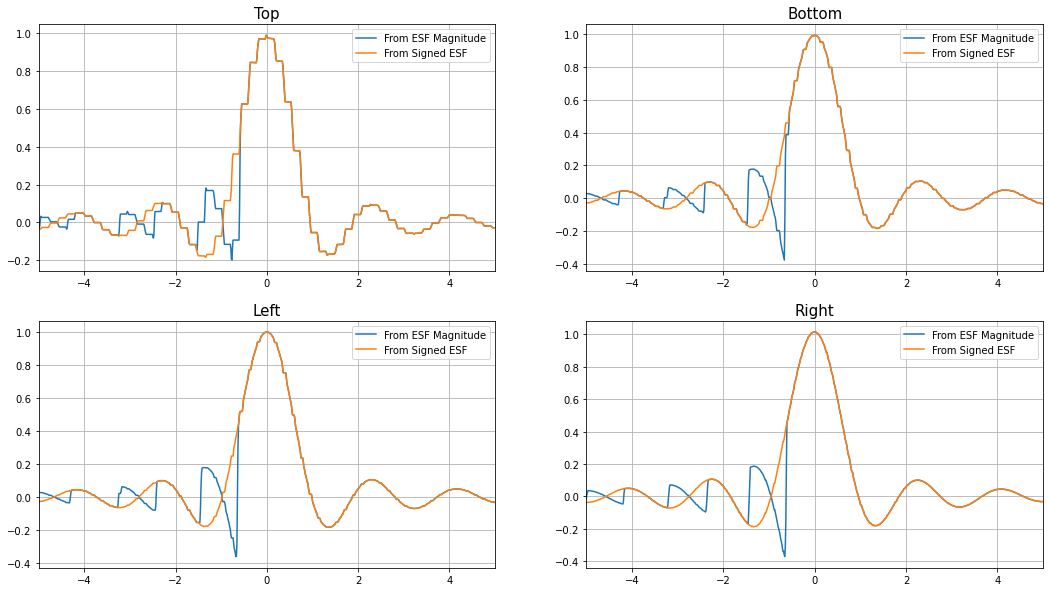

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
for ax, roiname in zip(axs.flat, ['Top', 'Bottom', 'Left', 'Right']):
    subroi = subrois[roiname]
    ny, nx = subroi.shape
    #slope, intercept, gain = fit_roi_model(subroi, model)
    x_mm, esf = esf_from_roi(subroi, pix_dims)
    x_mm_grid = np.linspace(x_mm.min(), x_mm.max(), 2048)
    
    esf_fitted = fitted_esf_abs(x_mm, esf, pix_dims[0])
    esf_grid = interp1d(x_mm, esf_fitted)(x_mm_grid)
    lsf_grid = lsf_from_esf(x_mm_grid, esf_grid)
    ax.plot(x_mm_grid, lsf_grid, label='From ESF Magnitude')

    esf_fitted = fitted_esf(x_mm, esf, pix_dims[0])
    esf_grid = interp1d(x_mm, esf_fitted)(x_mm_grid)
    lsf_grid = lsf_from_esf(x_mm_grid, esf_grid)
    ax.plot(x_mm_grid, lsf_grid, label='From Signed ESF')

    ax.legend()
    ax.set_xlim(-5, 5)
    ax.grid(True)
    ax.set_title(roiname, fontsize=15)

#### MTF with Lowess
##### With and without sign correction

Note, this is going wrong on the left where the first side lobe is rectified producing a gradient discontinuity that the lowess isn't following. 

/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')


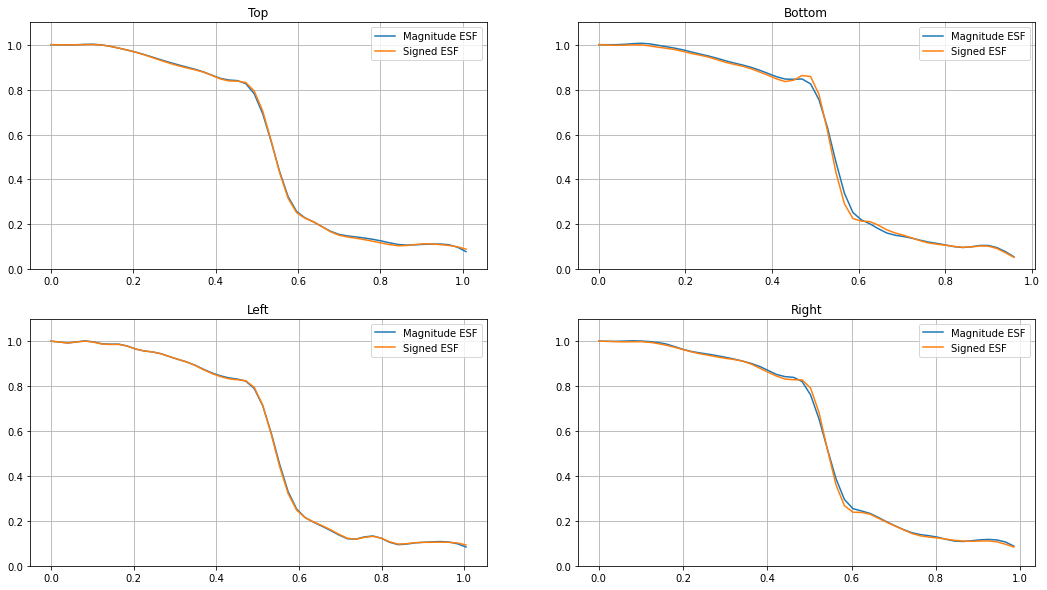

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
for ax, roiname in zip(axs.flat, ['Top', 'Bottom', 'Left', 'Right']):
    x_mm, esf = esf_from_roi(subrois[roiname], pix_dims)
    x_mm_grid, esf_grid = lowess_regrid(x_mm, esf)
    lsf_grid = lsf_from_esf(x_mm_grid, esf_grid)
    x_mtf, mtf = msf_from_lsf(x_mm_grid, lsf_grid)
    ax.plot(x_mtf[:50], mtf[:50], label='Magnitude ESF')
    
    esf_signed = esf * np.sign(fitted_esf(x_mm, esf, pix_dims[0]))
    x_mm_grid, esf_signed_grid = lowess_regrid(x_mm, esf_signed)
    lsf_signed_grid = lsf_from_esf(x_mm_grid, esf_signed_grid)    
    x_mtf, mtf = msf_from_lsf(x_mm_grid, lsf_signed_grid)
    ax.plot(x_mtf[:50], mtf[:50], label='Signed ESF')
    ax.legend()

    ax.set_ylim([0, 1.1])
    ax.grid(True)
    ax.set_title(roiname)

#### MTF with Model
##### With and without sign correction

/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')


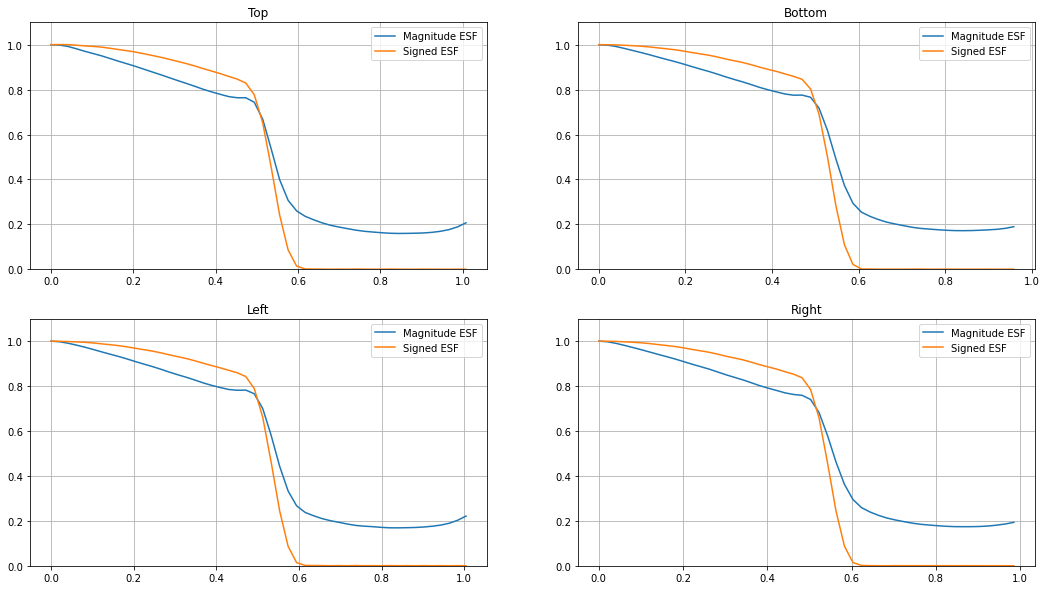

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
for ax, roiname in zip(axs.flat, ['Top', 'Bottom', 'Left', 'Right']):
    x_mm, esf = esf_from_roi(subrois[roiname], pix_dims)
    
    esf = fitted_esf_abs(x_mm, esf, pix_dims[0])
    x_mm_grid = np.linspace(x_mm.min(), x_mm.max(), 2048)
    esf_grid = interp1d(x_mm, esf)(x_mm_grid)
    lsf_grid = lsf_from_esf(x_mm_grid, esf_grid)
    x_mtf, mtf = msf_from_lsf(x_mm_grid, lsf_grid)
    ax.plot(x_mtf[:50], mtf[:50], label='Magnitude ESF')
    
    esf = fitted_esf(x_mm, esf, pix_dims[0])
    esf_grid = interp1d(x_mm, esf)(x_mm_grid)
    lsf_grid = lsf_from_esf(x_mm_grid, esf_grid)
    x_mtf, mtf = msf_from_lsf(x_mm_grid, lsf_grid)
    ax.plot(x_mtf[:50], mtf[:50], label='Signed ESF')
   
    ax.legend()
    ax.set_ylim([0, 1.1])
    ax.grid(True)
    ax.set_title(roiname)

## Summary Reports for Each Edge

In [66]:
def edge_analysis(roi, pix_dims, use_esf_model=True, correct_sign=True):
    x_mm, esf = esf_from_roi(roi, pix_dims)
    esf_fitted = fitted_esf(x_mm, esf, pix_dims[0])
    if correct_sign:
        esf *= np.sign(esf_fitted)

    x_mm_grid, esf_grid = lowess_regrid(x_mm, esf)

    if use_esf_model:
        esf_grid = interp1d(x_mm, esf_fitted)(x_mm_grid)

    lsf_grid = lsf_from_esf(x_mm_grid, esf_grid)
    assert x_mm_grid.shape == lsf_grid.shape
    x_mtf, mtf = msf_from_lsf(x_mm_grid, lsf_grid)
    return x_mm, esf, x_mm_grid, esf_grid, lsf_grid, x_mtf, mtf

In [67]:
def report_edge(roi, name, pix_dims, use_esf_model=True):
    x_mm, esf, x_mm_grid, esf_grid, lsf, x_mtf, mtf = edge_analysis(roi, pix_dims, use_esf_model=use_esf_model)
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    axs = axs.ravel()
    
    axs[0].imshow(roi)
    axs[0].axis('off')
    axs[0].set_title(name)

    axs[1].plot(x_mm, esf, '.')
    axs[1].plot(x_mm_grid, esf_grid)    
    axs[1].set_xlim(x_mm_grid[0], x_mm_grid[-1])
    axs[1].grid(True)
    axs[1].set_xlabel('mm')
    axs[1].set_title('Fitted Edge Spread Function')
    
    axs[2].plot(x_mm_grid, lsf)
    axs[2].grid(True)
    axs[2].set_xlabel('mm')
    axs[2].set_title('Windowed Line Spread Function')
    
    end = np.searchsorted(x_mtf, 1.25)
    axs[3].plot(x_mtf[:end], mtf[:end])
    axs[3].grid(True)
    axs[3].set_xlabel('Spatial Frequency (cycles per mm)')
    axs[3].set_title('Modulation Transfer Function')

    return x_mm_grid, esf_grid, lsf, x_mtf, mtf

/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')


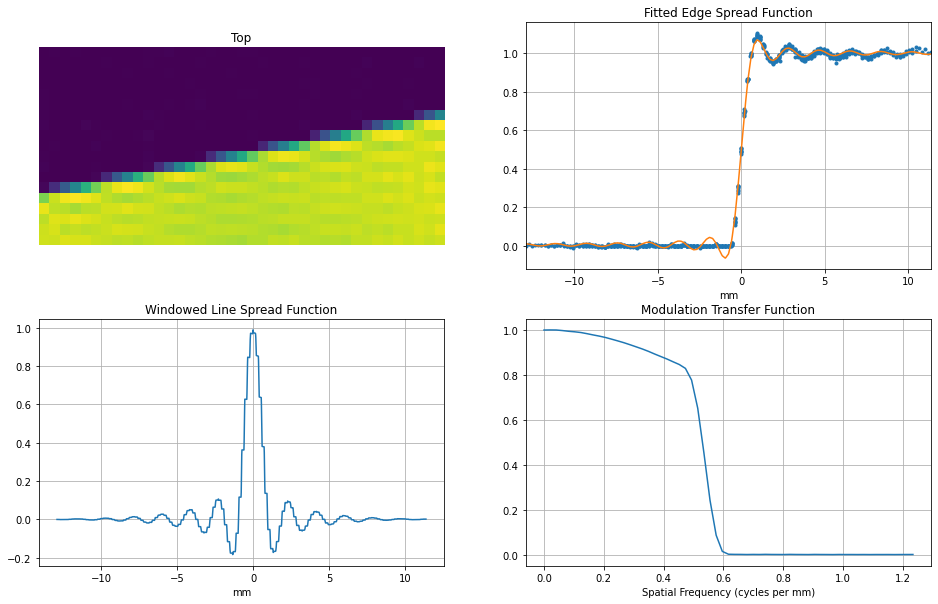

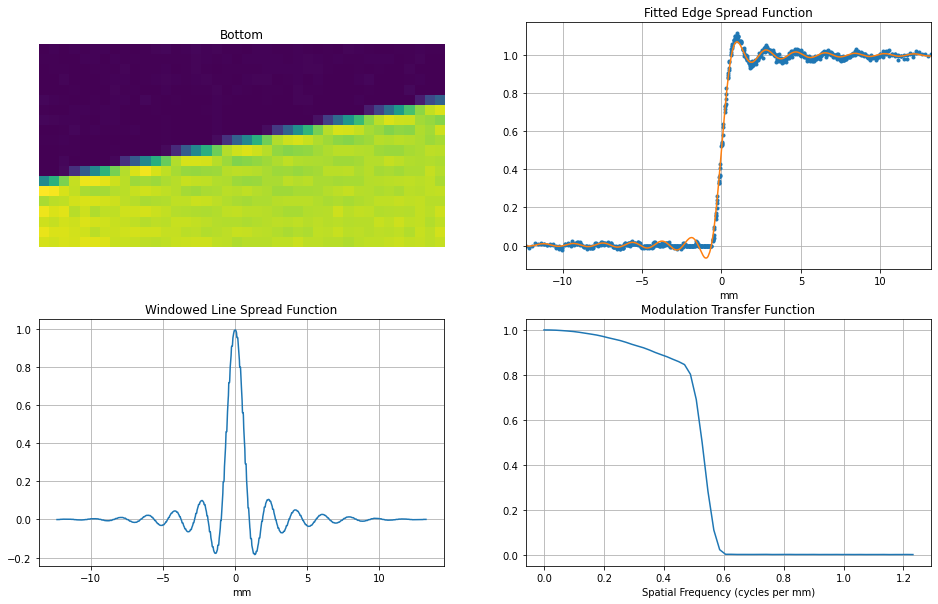

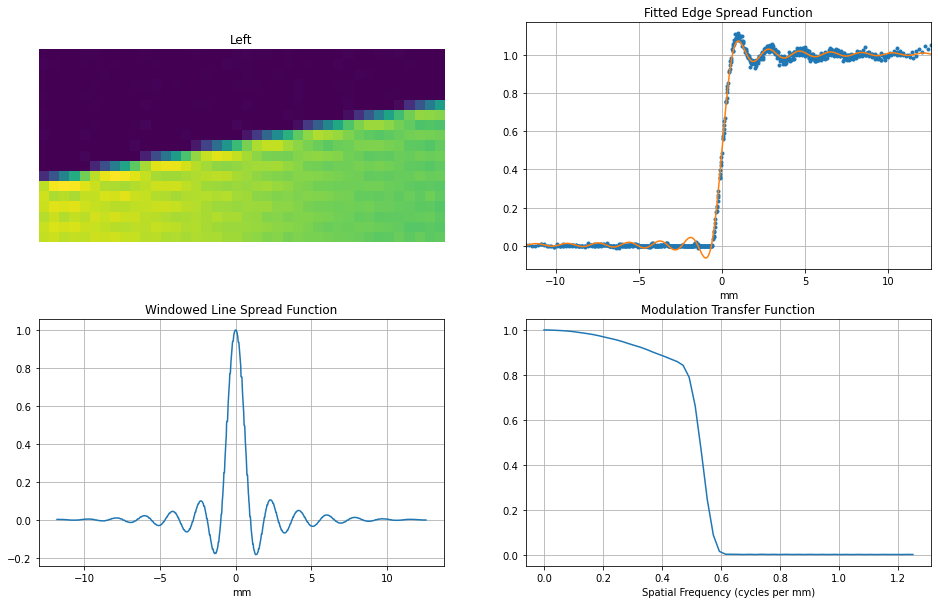

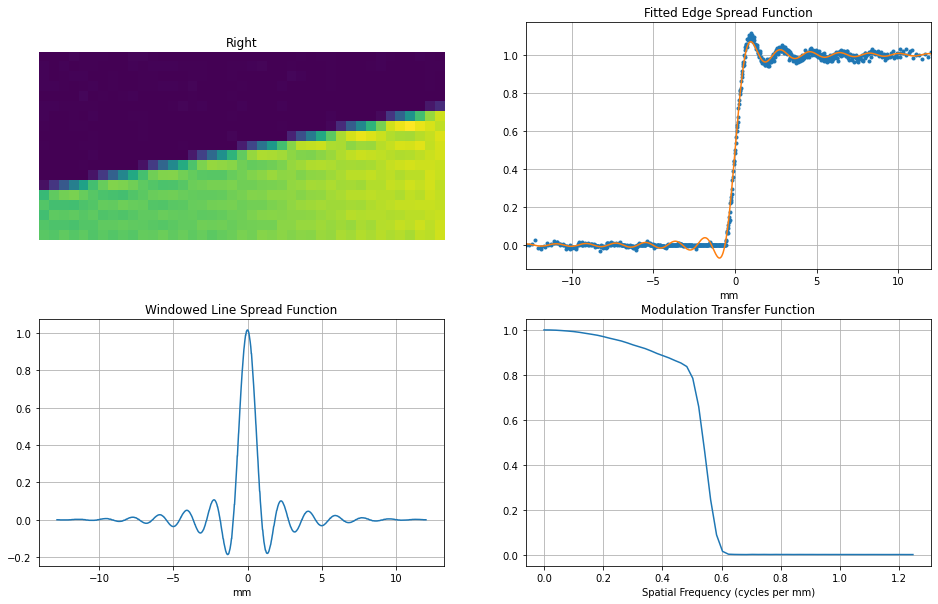

In [68]:
x_mm_grid, esf_grid, lsf, x_mtf, mtf = report_edge(subrois['Top'], 'Top', pix_dims)
plt.show()
x_mm_grid, esf_grid, lsf, x_mtf, mtf = report_edge(subrois['Bottom'], 'Bottom', pix_dims)
plt.show()
x_mm_grid, esf_grid, lsf, x_mtf, mtf = report_edge(subrois['Left'], 'Left', pix_dims)
plt.show()
x_mm_grid, esf_grid, lsf, x_mtf, mtf = report_edge(subrois['Right'], 'Right', pix_dims)
plt.show()

## ESF for each method

/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')


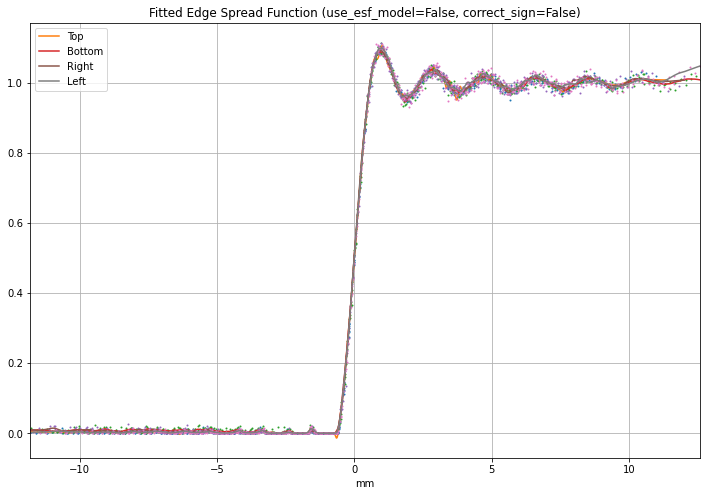

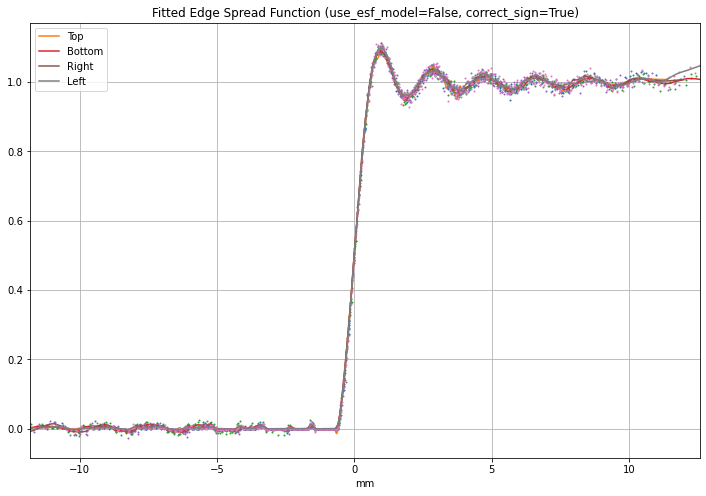

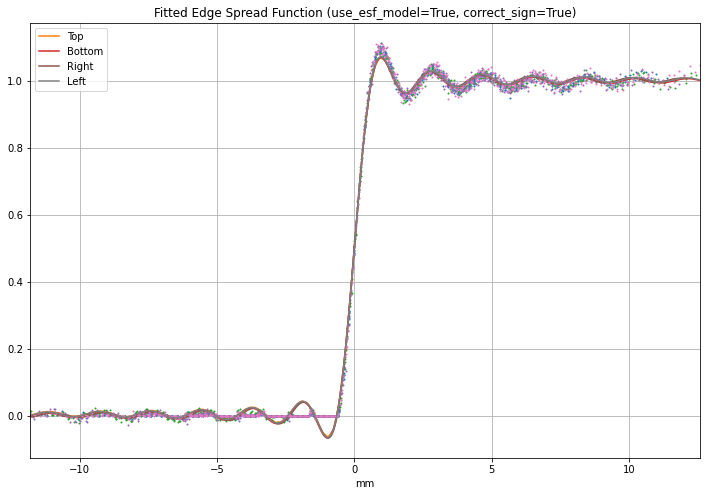

In [69]:
def plot_edge_responses(rois, pix_dims, use_esf_model=True, correct_sign=True):
    fig, ax = plt.subplots(figsize=(12, 8))
    for name, roi in rois.items():
        x_mm, esf, x_mm_grid, esf_grid, lsf, x_mtf, mtf = edge_analysis(
            roi, pix_dims, use_esf_model=use_esf_model, correct_sign=correct_sign
        )
        ax.plot(x_mm, esf, '.', markersize=2)
        ax.plot(x_mm_grid, esf_grid, label=name)
        ax.set_xlim(x_mm_grid[0], x_mm_grid[-1])
        ax.grid(True)
        ax.set_xlabel('mm')
        ax.set_title(f'Fitted Edge Spread Function (use_esf_model={use_esf_model}, correct_sign={correct_sign})')
        ax.legend()

plot_edge_responses(subrois, pix_dims, use_esf_model=False, correct_sign=False)
plot_edge_responses(subrois, pix_dims, use_esf_model=False, correct_sign=True)
plot_edge_responses(subrois, pix_dims, use_esf_model=True)

## LSF for each method

/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')


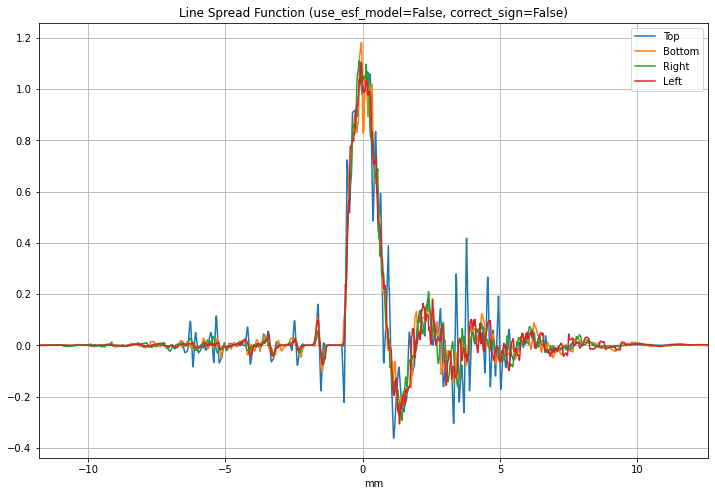

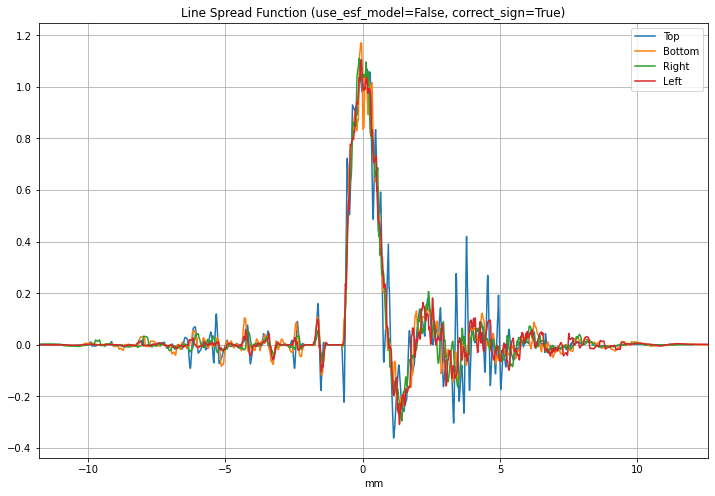

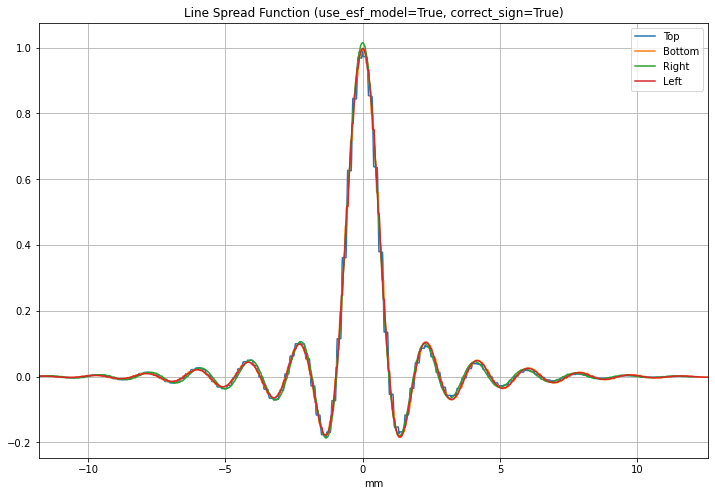

In [70]:
def plot_line_responses(rois, pix_dims, use_esf_model=True, correct_sign=True):
    fig, ax = plt.subplots(figsize=(12, 8))
    for name, roi in rois.items():
        x_mm, esf, x_mm_grid, esf_grid, lsf, x_mtf, mtf = edge_analysis(
            roi, pix_dims, use_esf_model=use_esf_model, correct_sign=correct_sign
        )
        ax.plot(x_mm_grid, lsf, label=name)    
        ax.set_xlim(x_mm_grid[0], x_mm_grid[-1])
        ax.grid(True)
        ax.set_xlabel('mm')
        ax.set_title(f'Line Spread Function (use_esf_model={use_esf_model}, correct_sign={correct_sign})')
        ax.legend()

plot_line_responses(subrois, pix_dims, use_esf_model=False, correct_sign=False)
plot_line_responses(subrois, pix_dims, use_esf_model=False, correct_sign=True)
plot_line_responses(subrois, pix_dims, use_esf_model=True)

## MTF for each method

/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')


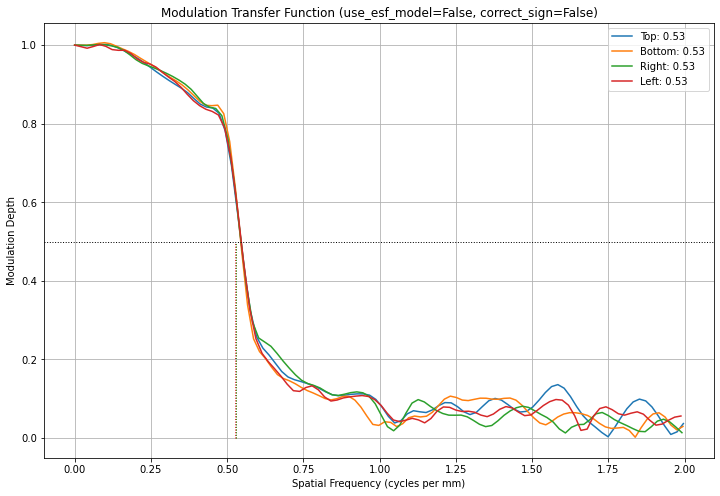

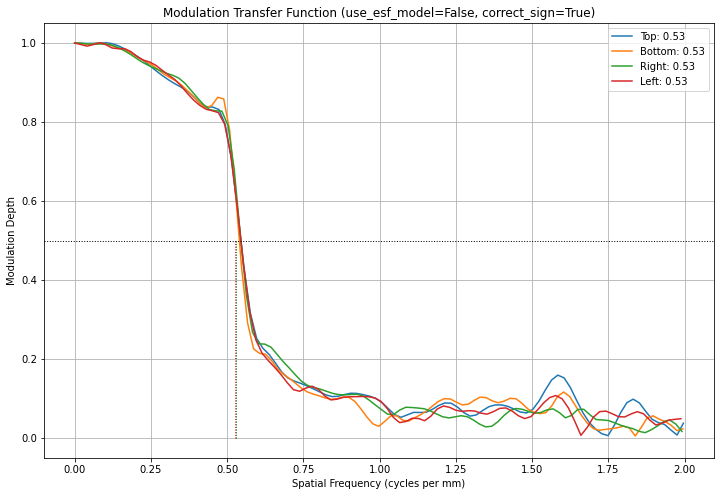

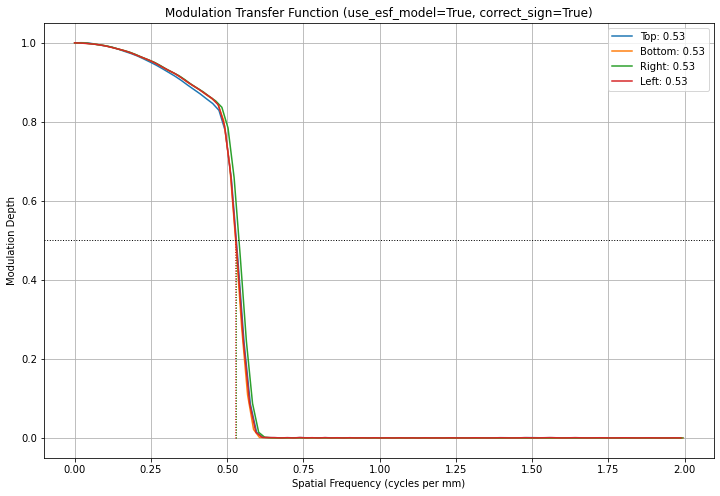

In [71]:
def plot_mtfs(rois, pix_dims, use_esf_model=True, correct_sign=True, cutoff_freq=2.0):   
    def _half_max(x, y):
        x_i = np.linspace(x[0], x[-1], 50)
        y_i = interp1d(x, y)(x_i)
        return x_i[(abs(y_i - 0.5)).argmin()] 

    fig, ax = plt.subplots(figsize=(12, 8))
    for name, roi in rois.items():
        *_, x_mtf, mtf = edge_analysis(roi, pix_dims, use_esf_model=use_esf_model, correct_sign=correct_sign)
    
        cutoff_index = np.searchsorted(x_mtf, cutoff_freq)
        x_mtf, mtf = x_mtf[:cutoff_index], mtf[:cutoff_index]
        halfmax = _half_max(x_mtf, mtf)

        p = ax.plot(x_mtf, mtf, label='%s: %0.2f' % (name, halfmax))
        ax.vlines(halfmax, 0, 0.5, color=p[0].get_color(), linewidth=1, linestyle='dotted')

    ax.grid(True)
    ax.set_xlabel('Spatial Frequency (cycles per mm)')
    ax.set_ylabel('Modulation Depth')
    ax.set_title(f'Modulation Transfer Function (use_esf_model={use_esf_model}, correct_sign={correct_sign})')
    ax.legend()
    ax.axhline(0.5, linewidth=1, color='black', linestyle='dotted')

plot_mtfs(subrois, pix_dims, use_esf_model=False, correct_sign=False)
plot_mtfs(subrois, pix_dims, use_esf_model=False, correct_sign=True)
plot_mtfs(subrois, pix_dims, use_esf_model=True)

### Summary reports for groups of edges

In [72]:
import pandas as pd

def report_edge_rois(rois, pix_dims, use_esf_model=False, correct_sign=True, cutoff_freq=1.0):
    def _half_max(x, y):
        x_interp = np.linspace(x[0], x[-1], 50)
        y_interp = interp1d(x, y)(x_interp)
        return x_interp[(abs(y_interp - 0.5)).argmin()]
    
    halfmaxes = []
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    for name, roi in rois.items():
        x_mm, esf, x_mm_grid, esf_grid, lsf, x_mtf, mtf = edge_analysis(
            roi, pix_dims, use_esf_model=use_esf_model, correct_sign=correct_sign
        )
        cutoff_index = np.searchsorted(x_mtf, cutoff_freq)
        x_mtf, mtf = x_mtf[:cutoff_index+1], mtf[:cutoff_index+1]       
        halfmax = _half_max(x_mtf, mtf)
        halfmaxes.append(halfmax)

        ax = axs[0]
        ax.plot(x_mm, esf, '.', markersize=2, color='black')
        ax.plot(x_mm_grid, esf_grid, label=name)    
        ax.set_xlim(x_mm_grid[0], x_mm_grid[-1])
        
        ax = axs[1]
        ax.plot(x_mm_grid, lsf, label=name)    
        ax.set_xlim(x_mm_grid[0], x_mm_grid[-1])

        ax = axs[2]
        p = ax.plot(x_mtf, mtf, label='%s: %0.2f' % (name, halfmax))
        ax.vlines(halfmax, 0, 0.5, color=p[0].get_color(), linewidth=1, linestyle='dotted')

    ax = axs[0]
    ax.grid(True)
    ax.set_xlabel('Distance from Edge (mm)')
    ax.set_ylabel('Normalised Brightness')
    ax.set_title('Fitted Edge Spread Function')
    ax.legend()
    
    ax = axs[1]
    ax.grid(True)
    ax.set_xlabel('Distance from Edge (mm)')
    ax.set_title('Line Spread Function (Windowed)')
    ax.legend()
    
    ax = axs[2]
    # we realy want the cutoff frequency to depend on the pixel size ... 
    ax.set_xlim(0, cutoff_freq)
    ax.grid(True)
    ax.set_xlabel('Spatial Frequency (cycles per mm)')
    ax.set_ylabel('Modulation Depth')
    ax.set_title('Modulation Transfer Function')
    ax.axhline(0.5, linewidth=1, color='black', linestyle='dotted')
    ax.legend()
    
    # need to add code to calculate FWHM of line response and similar from MTF
    return pd.DataFrame({'MTF_HalfMax': halfmaxes}, index=rois.keys())


### Horizontal Edges

/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')


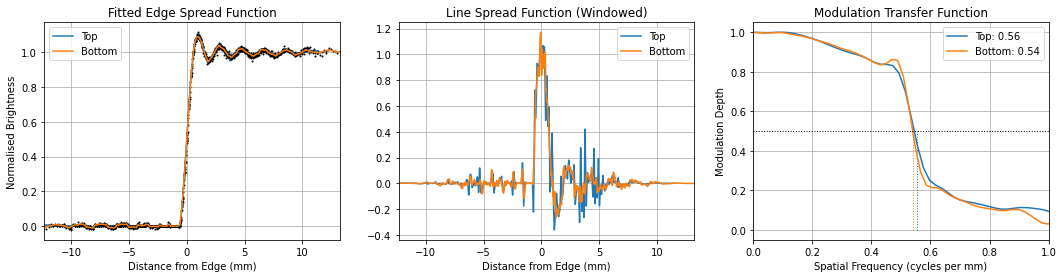

MTF_HalfMax
Top        0.555454
Bottom     0.539435

In [73]:
x = report_edge_rois({
        k: subroi for (k, subroi) in subrois.items() if k in {'Top', 'Bottom'}
    }, pix_dims)
plt.show()
x

### Vertical Edges

/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')


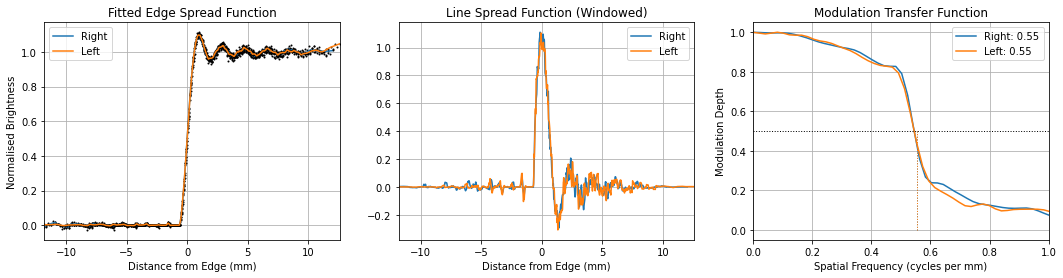

MTF_HalfMax
Right     0.554047
Left      0.553241

In [74]:
x = report_edge_rois({
    k: subroi for (k, subroi) in subrois.items() if k in {'Left', 'Right'}
}, pix_dims)
plt.show()
x

### All Edges Together

/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')
/tmp/ipykernel_30585/1694572567.py:89: UserWarning: MTF maximum is not at zero
  warn('MTF maximum is not at zero')


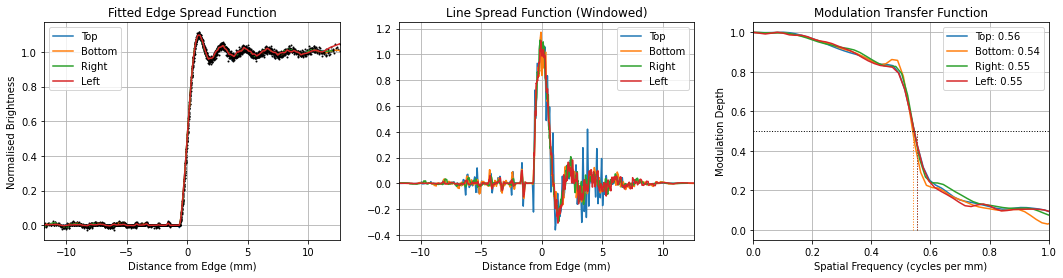

MTF_HalfMax
Top        0.555454
Bottom     0.539435
Right      0.554047
Left       0.553241

In [75]:
x = report_edge_rois(subrois, pix_dims)
plt.show()
x

- Using PSN or applying a gain field  after the event will make the top of the curve tighter *but* it will also do something to the noise and so disort the bottom if the graph.

----